In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2 as cv
import sys

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.coordinates import SkyCoord

import numpy as np
from scipy import special
from scipy.stats import kstwobign, anderson
import scipy.stats.distributions as dist

import matplotlib 
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

In [2]:
combine_fold = 'C:/Users/oryan/Documents/mergers-in-cosmos/cats-to-combine'
data_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/back-to-basics-data'
fig_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/paper-source/figures'

In [3]:
df_cat = pd.read_csv(f'{combine_fold}/dor-all-restaged-full-rem-seps-z.csv', index_col = 0)

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df_cat

,ID,ORyanID_23,category,ALPHA_J2000,DELTA_J2000,X_IMAGE,Y_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,ERRXY_IMAGE,...,ez_ssfr_p025,ez_ssfr_p160,ez_ssfr_p500,ez_ssfr_p840,ez_ssfr_p975,ez_Av_p025,ez_Av_p160,ez_Av_p500,ez_Av_p840,ez_Av_p975
0,816891,4000705532455,stage4,150.679846,2.196543,9200.399414,21737.232422,0.000052,0.000059,-1.043282e-05,...,-8.931825,-8.911355,-8.899668,-8.883307,-8.872990,0.529107,0.560142,0.599624,0.630920,0.652330
1,860686,4000705533383,stage3,150.644522,2.237226,10047.978516,22713.351562,0.000051,0.000046,1.571297e-06,...,-9.314209,-9.106611,-8.941274,-8.713107,-8.541205,0.341270,0.545498,0.732327,0.906665,1.020098
2,1301188,4000705539941,stage2,149.702462,2.654895,32637.949219,32737.013672,0.000064,0.000104,-2.881107e-06,...,-9.794128,-9.784252,-9.766013,-9.743796,-9.727879,0.018737,0.018737,0.018737,0.018737,0.018737
3,1304538,4000705540034,stage3,149.726828,2.658172,32053.712891,32815.468750,0.000071,0.000086,-6.036952e-06,...,-9.480532,-9.443615,-9.402433,-9.352081,-9.325659,0.302629,0.376027,0.440394,0.508153,0.567727
4,1310001,4000705540064,stage3,149.701230,2.660343,32667.441406,32867.789062,0.000026,0.000020,-1.023530e-05,...,-9.882174,-9.855921,-9.816085,-9.697225,-9.573506,0.455258,0.482555,0.522239,0.600383,0.660279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3927,1520733,4001204758614_extra,stage4,149.891374,2.866981,28107.876953,37826.437500,0.000086,0.000104,-9.313976e-07,...,-9.441206,-9.279022,-9.095134,-9.003501,-8.955496,0.120441,0.213251,0.306832,0.556012,0.731876
3928,1520749,4546055995_extra,stage2,150.383110,2.865367,16320.103516,37787.917969,0.000131,0.000236,7.123858e-05,...,-9.857880,-9.658215,-9.485625,-9.235816,-8.971795,0.162147,0.238640,0.432004,0.592193,0.687256
3929,1523385,4000927318133_extra,stage3,149.789910,2.865132,30540.179688,37782.648438,0.000045,0.000059,1.600747e-05,...,-9.525900,-9.472779,-9.353454,-9.273221,-9.213521,0.262676,0.355466,0.410356,0.489105,0.566003
3930,1524909,4000747939904_extra,stage3,150.450581,2.872371,14702.710938,37956.468750,0.000248,0.000292,7.378556e-06,...,-9.556987,-9.385500,-9.154130,-9.026810,-8.938077,0.153294,0.283249,0.436332,0.600615,0.693621


In [5]:
df_red_tmp = df_cat.query('ez_sfr < 10')
df_red = df_red_tmp.query('lp_mass_best > 9.25')

In [6]:
df_noextra = (
    df_red
    .assign(extra_cont = df_red.ORyanID_23.apply(lambda x: 'y' if type(x) == str and 'extra' in x else 'n'))
    .query('extra_cont == "n"')
    .drop(columns = ['extra_cont'])
)

In [7]:
len(df_noextra)

2567

In [8]:
def create_plot_ez(df, ax, stage, control):
    
#     ax_histx = fig.add_subplot(gs[0,0],sharex=ax)
#     ax_histy = fig.add_subplot(gs[1,1],sharey=ax)
    
#     scatter_hist(np.array(list(df.mass_best_1)), np.array(list(df.sfr_best_1)), ax, ax_histx, ax_histy, 'black')
    
    df.plot.scatter(
        x = 'lp_mass_best',
        y = 'ez_sfr',
        ax = ax,
        xlim = [9.1,12.1],
        ylim = [-6,3.0],
        xlabel = '',
        ylabel = '',
        title = f'{control} {stage}',
        color = 'black',
        alpha = 0.25,
        s = 5
    )

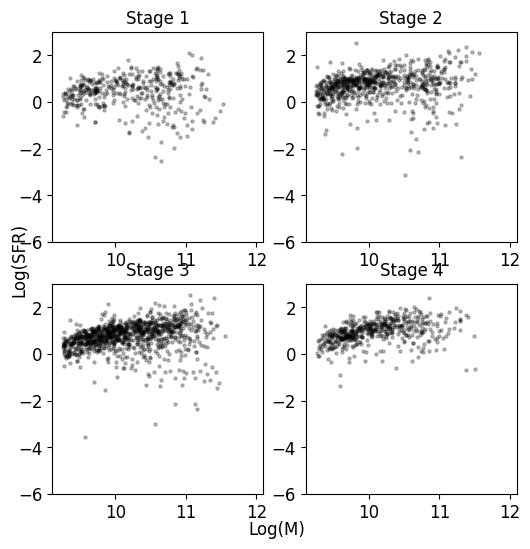

In [9]:
counter = 1
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (6,6))
for i in range(2):
    for j in range(2):
        create_plot_ez(df_noextra.query(f'category == "stage{counter}"'), axes[i,j], counter, 'Stage')
        counter += 1
        
fig.text(0.5, 0.05, 'Log(M)', ha='center', va='center', fontsize = 12)
fig.text(0.07, 0.5, 'Log(SFR)', ha='center', va='center', rotation='vertical', fontsize = 12)

plt.show()

In [10]:
def scatter_hist(x, y, ax, ax_histx, ax_histy, colour):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, s = 0.5, color=colour, alpha = 0.25)
    #threshold = 0.065
    sns.kdeplot(x=x,y=y, ax=ax, thresh = 0.05, levels=8, color='orange')
    ax.set_xlim([8.9,12.15])
    ax.set_ylim([-5, 3.5])

    # now determine nice limits by hand:
    binwidth = 0.15
    xymax = max(12.5, 3.5)
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins, histtype = 'step', color = colour)
    ax_histy.hist(y, bins=bins, orientation='horizontal', histtype='step', color=colour)

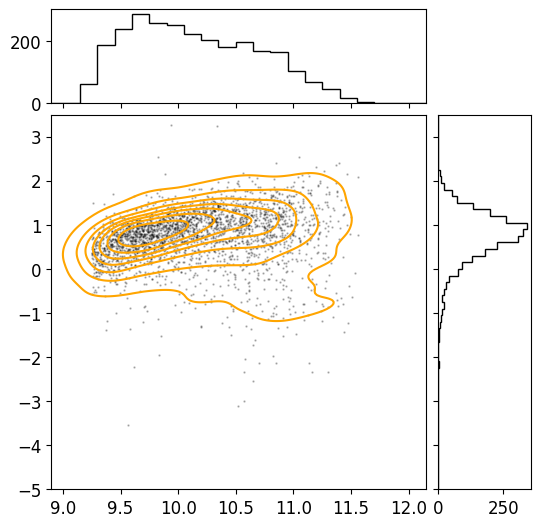

In [12]:
fig = plt.figure(figsize = (6,6))
gs = fig.add_gridspec(2,2, width_ratios = (4,1), height_ratios = (1,4), left = 0.1, right = 0.9, bottom = 0.1, top = 0.9, wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1,0])
ax_histx = fig.add_subplot(gs[0,0],sharex=ax)
ax_histy = fig.add_subplot(gs[1,1],sharey=ax)

# colours = ['black','blue','red','orange']

scatter_hist(np.array(list(df_noextra.lp_mass_best)), np.array(list(df_noextra.ez_sfr)), ax, ax_histx, ax_histy, 'black')

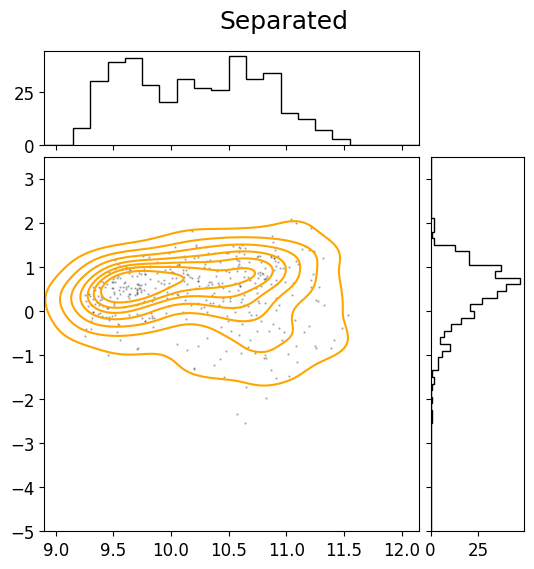

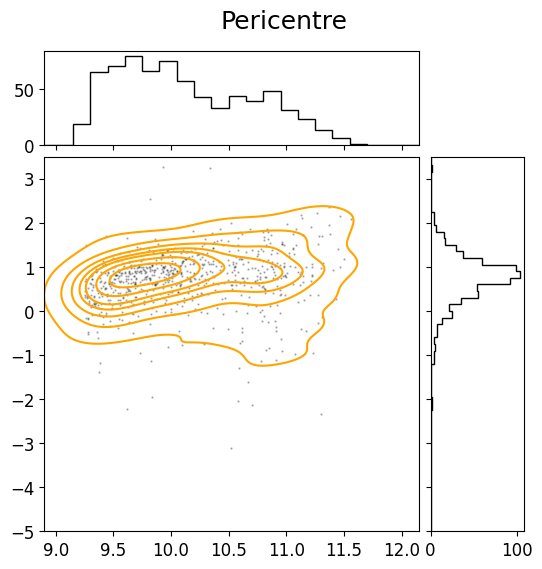

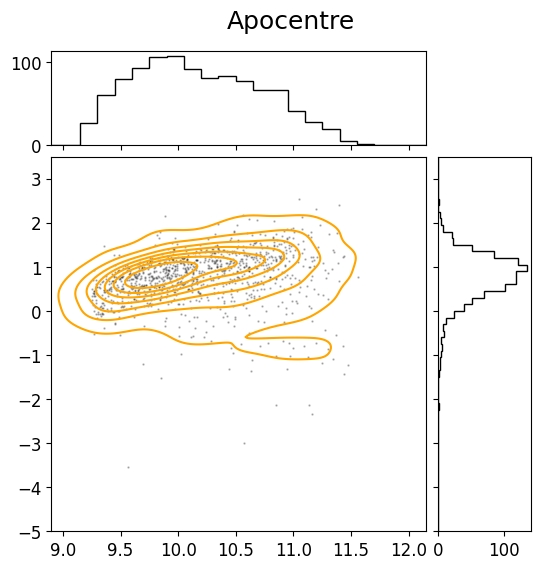

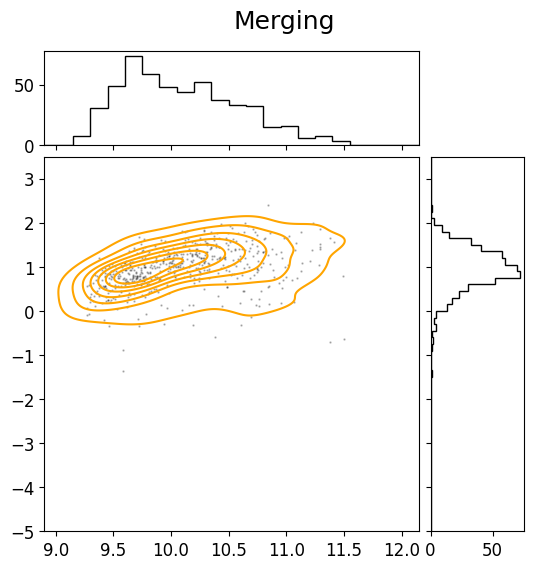

In [70]:
# colours = ['black','blue','red','orange']
stage_list = ['Separated','Pericentre','Apocentre','Merging']

for i in range(0,4):
    
    fig = plt.figure(figsize = (6,6))
    gs = fig.add_gridspec(2,2, width_ratios = (4,1), height_ratios = (1,4), left = 0.1, right = 0.9, bottom = 0.1, top = 0.9, wspace=0.05, hspace=0.05)

    ax = fig.add_subplot(gs[1,0])
    ax_histx = fig.add_subplot(gs[0,0],sharex=ax)
    ax_histy = fig.add_subplot(gs[1,1],sharey=ax)
    
    df_stage = df_noextra.query(f'category == "stage{i+1}"')

    scatter_hist(np.array(list(df_stage.lp_mass_best)), np.array(list(df_stage.ez_sfr)), ax, ax_histx, ax_histy, 'black')
    
    fig.text(0.5, 0.95, f'{stage_list[i]}', ha='center', va='center', fontsize = 18)
    
    plt.savefig(f'{fig_folder}/stage{i+1}.jpeg', bbox_inches = 'tight', dpi = 500)
    
    plt.show()

### Testing with Image Trick

In [71]:
fig_folder

'C:/Users/oryan/Documents/mergers-in-cosmos/paper-source/figures'

In [72]:
im_files = glob.glob(f'{fig_folder}/sfr-stages/*.jpeg')

In [73]:
im_files

['C:/Users/oryan/Documents/mergers-in-cosmos/paper-source/figures/sfr-stages\\stage1.jpeg',
 'C:/Users/oryan/Documents/mergers-in-cosmos/paper-source/figures/sfr-stages\\stage2.jpeg',
 'C:/Users/oryan/Documents/mergers-in-cosmos/paper-source/figures/sfr-stages\\stage3.jpeg',
 'C:/Users/oryan/Documents/mergers-in-cosmos/paper-source/figures/sfr-stages\\stage4.jpeg']

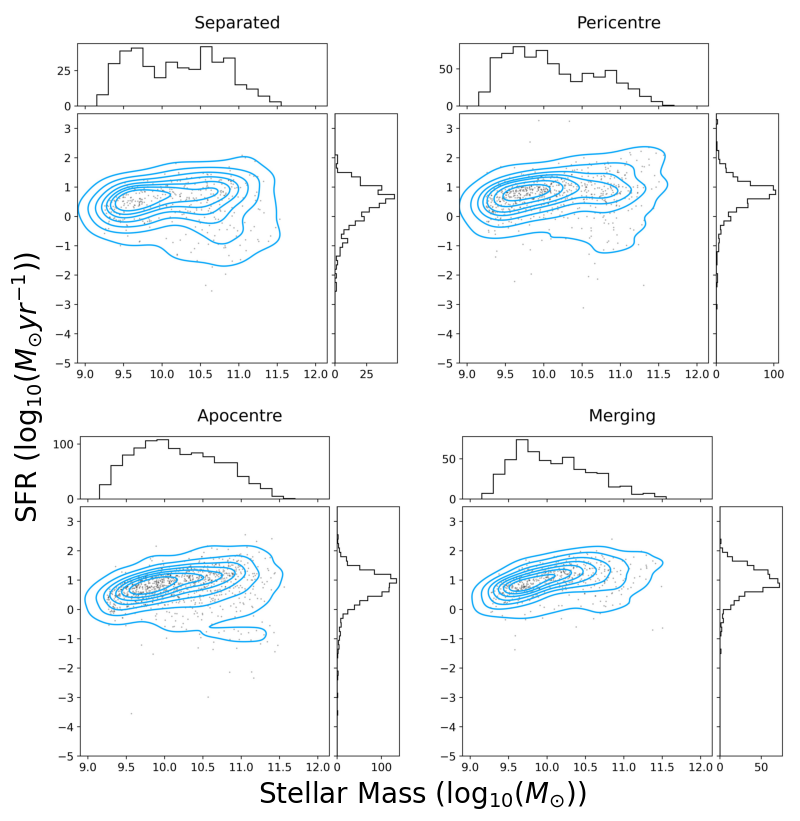

In [75]:
fig, ax = plt.subplots(nrows=2,ncols = 2, figsize = (8,8))
counter = 0
for i in range(2):
    for j in range(2):
        im = cv.imread(im_files[counter])
        ax[i,j].imshow(im)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].axis('off')
        counter += 1
fig.text(-0.01,0.35, 'SFR ($\log_{10}(M_{\odot}yr^{-1}$))', fontsize = 20, rotation = 90, alpha = 1)
fig.text(0.30,-0.01, 'Stellar Mass ($\log_{10}(M_{\odot})$)', fontsize = 20, alpha = 1)
fig.tight_layout()
fig.savefig(f'{fig_folder}/sfr-mass-stages.pdf', bbox_inches = 'tight')
plt.show()

### Mass Distribution of Stages
Here, and in the next section, I want to build some normalised histograms of the masses and sfrs of the different stages.

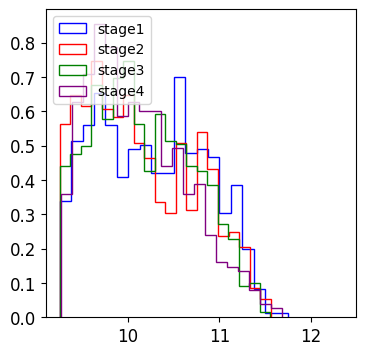

In [76]:
plt.figure(figsize = (4,4))
plt.hist(df_red.query('category == "stage1"')['lp_mass_best'], bins = 20, histtype='step', color='blue', density = True)
plt.hist(df_red.query('category == "stage2"')['lp_mass_best'], bins = 20, histtype='step', color='red', density = True)
plt.hist(df_red.query('category == "stage3"')['lp_mass_best'], bins = 20, histtype='step', color='green', density = True)
plt.hist(df_red.query('category == "stage4"')['lp_mass_best'], bins = 20,histtype='step', color='purple', density = True)
plt.legend(['stage1','stage2','stage3','stage4'], loc = 'upper left')
plt.xlim([9.1,12.5])
plt.show()

### Star Formation Between Stages

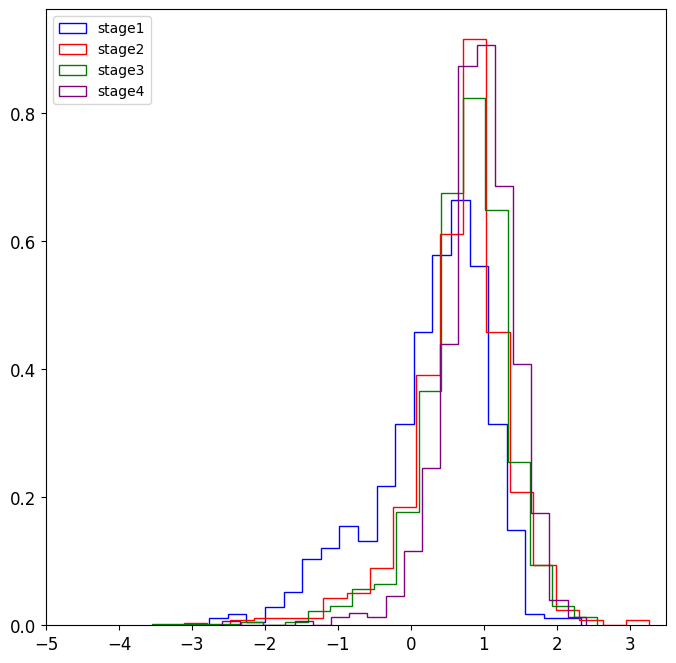

In [77]:
plt.figure(figsize = (8,8))
plt.hist(df_red.query('category == "stage1"')['ez_sfr'], bins = 20, histtype='step', color='blue', density = True)
plt.hist(df_red.query('category == "stage2"')['ez_sfr'], bins = 20, histtype='step', color='red', density = True)
plt.hist(df_red.query('category == "stage3"')['ez_sfr'], bins = 20, histtype='step', color='green', density = True)
plt.hist(df_red.query('category == "stage4"')['ez_sfr'], bins = 20, histtype='step', color='purple', density = True)
plt.legend(['stage1','stage2','stage3','stage4'], loc='upper left')
plt.xlim([-5,3.5])
plt.show()

### Running KS Test

In [78]:
def weight_dist(arrs, bins=None, return_bins=True, renorm=False):
    # this will take 2 arrays of values from 2 different samples
    # e.g. redshift distributions from 2 samples
    # and return weights for each value such that the weighted
    # distributions of each sample will match.

    # note the bins need to be the same for both datasets
    # so either supply 1 number or 1 array of bin edges
    # also if you have fully specified the bins you don't need them returned
    # but if we've had to figure them out, you do need them returned
    # if you want to make sure you aren't under-weighting (e.g. if a whole dataset is
    # much larger than the other so you might always be able select >1 object
    # in dataset 1 for each object in dataset 2) then you can re-normalise to make
    # sure the max weight of both datasets is 1
    # Note, if the distributions cross this won't make a difference

    # weight arrays
    # w1 = np.zeros_like(arr1)
    # w2 = np.zeros_like(arr2)
    
    ws_list = []
    for i in arrs:
        ws_list.append(np.zeros_like(i))

    # if bins not specified, guess at them ourselves
    if bins is None:
        minsize = np.amin([    len(arr1),     len(arr2)])
        themin  = np.amin([np.amin(arr1), np.amin(arr2)])
        themax  = np.amax([np.amax(arr1), np.amax(arr2)])

        # on average 5 data points per bin, but at least 3 bins pls, max value is last bin edge
        bins = np.linspace(themin, themax, int(np.amax([(minsize/5)+1, 3])), endpoint=True)

    else:
        pass
        # because the np.histogram function can deal with distinguishing between number of bins or specific bins itself
        # so we don't have to
    hists = []
    hist1, thebins = np.histogram(arrs[0], bins=bins)  # returns (counts_arr, bins_arr)
    # use the bins from hist1 to make hist2
    # note: for these purposes, any values of hist2 outside the minmax range of hist1 should have 0 weight
    # which is taken care of by the zeros_like initialisation of w1 and w2 above
    # so it's fine for them to be excluded below
    hists.append(hist1)
    for i in arrs[1:]:
        hist_tmp, thebins = np.histogram(i, bins=thebins)
        hists.append(hist_tmp)

    # now step through the bins and assign weights
    for i_bin in range(len(thebins)-1):
        for i_hist in range(len(hists)-1):
            # zero-"index"ing these because they're indices and not values
            # and if I get them mixed up below I want this to error that there's no b2 or whatever
            b0 = thebins[i_bin]
            b1 = thebins[i_bin+1]

            count1 = hists[3][i_bin]
            count2 = hists[i_hist][i_bin]

            # don't miss any values and don't double-count
            if i_bin == 0:
                in_bin1 = (arrs[3] >= b0) & (arrs[3] <= b1)
                in_bin2 = (arrs[i_hist] >= b0) & (arrs[i_hist] <= b1)
            else: 
                in_bin1 = (arrs[3] >  b0) & (arrs[3] <= b1)
                in_bin2 = (arrs[i_hist] >  b0) & (arrs[i_hist] <= b1)


            # don't divide by 0 in the rest of the if/else
            if (count1 == 0) | (count2 == 0):
                ws_list[3][in_bin1] = 0.0
                ws_list[i_hist][in_bin2] = 0.0

            elif count1 < count2:
                # weight count2 values so the sum of wt2 in this bin equals count1
                # wt_fac will always be < 1
                wt_fac = float(count1)/float(count2)
                ws_list[3][in_bin1] = 1.0
                ws_list[i_hist][in_bin2] = wt_fac

            else:
                # weight count1 values so the sum of wt1 in this bin equals count2
                # wt_fac will always be <= 1
                wt_fac = float(count2)/float(count1)
                ws_list[3][in_bin1] = wt_fac
                ws_list[i_hist][in_bin2] = 1.0


    # now the weights should be determined
    # we can optionally re-normalise to make sure we are getting max value out of the datasets
    if renorm:
        if (np.sum(ws) > 0.00000) & (np.amax(w1) < 1.0):
            ws /= np.amax(ws)

        if (np.sum(ws) > 0.00000) & (np.amax(w2) < 1.0):
            ws /= np.amax(ws)


    if return_bins:
        return ws, thebins 
    else: 
        return ws_list

In [79]:
masses_s1 = np.array(df_noextra.query('category == "stage1"')['lp_mass_best'])
masses_s2 = np.array(df_noextra.query('category == "stage2"')['lp_mass_best'])
masses_s3 = np.array(df_noextra.query('category == "stage3"')['lp_mass_best'])
masses_s4 = np.array(df_noextra.query('category == "stage4"')['lp_mass_best'])

In [80]:
weights = weight_dist([masses_s1, masses_s2, masses_s3, masses_s4], bins = 20, renorm = False, return_bins = False)
# weights_s1_s3, weights_s3 = weight_dist(masses_s1, masses_s3, bins = 20, renorm = False, return_bins = False)
# weights_s1_s4, weights_s4 = weight_dist(masses_s1, masses_s4, bins = 20, renorm = False, return_bins = False)

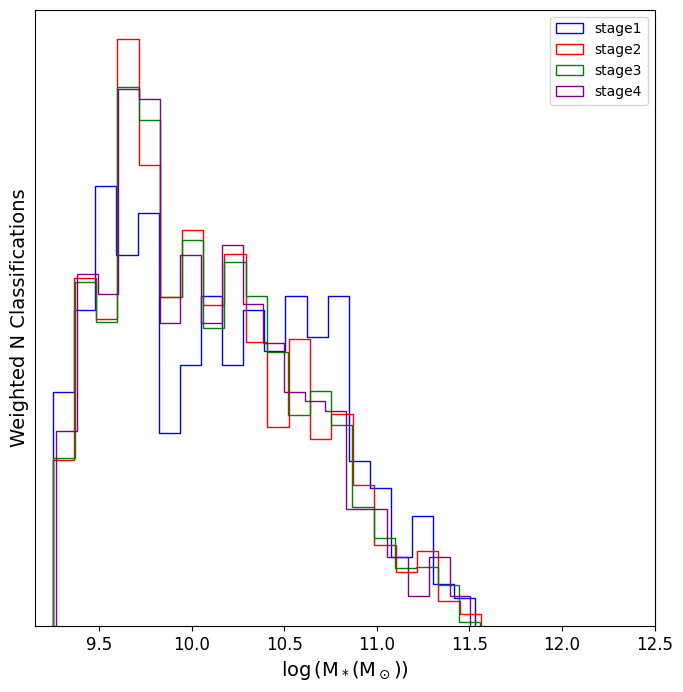

In [81]:
fig, ax = plt.subplots(figsize = (8,8))

# ax.hist(masses_s1, bins = 20, histtype='step', color='blue', weights=weights[0])
# ax.hist(masses_s2, bins = 20, histtype='step', color='red', weights=weights[1])
# ax.hist(masses_s3, bins = 20, histtype='step', color='green', weights=weights[2])
# ax.hist(masses_s4, bins = 20, histtype='step', color='purple',weights=weights[3])

ax.hist(masses_s1, bins = 20, histtype='step', color='blue', weights=weights[0],density=True)
ax.hist(masses_s2, bins = 20, histtype='step', color='red', weights=weights[1],density=True)
ax.hist(masses_s3, bins = 20, histtype='step', color='green', weights=weights[2],density=True)
ax.hist(masses_s4, bins = 20, histtype='step', color='purple',weights=weights[3],density=True)

plt.legend(['stage1','stage2','stage3','stage4'], loc='upper right')
plt.xlim([9.15,12.5])
plt.tick_params(left = False, labelleft=False)
plt.xlabel('$\log$(M$_*$(M$_\odot$))', fontsize = 14)
plt.ylabel('Weighted N Classifications', fontsize = 14)
# plt.savefig(f'{fig_folder}/stellar-mass-dist.pdf', bbox_inches = 'tight')
plt.show()

In [82]:
sfr_s1 = np.array(df_noextra.query('category == "stage1"')['ez_sfr'])
sfr_s2 = np.array(df_noextra.query('category == "stage2"')['ez_sfr'])
sfr_s3 = np.array(df_noextra.query('category == "stage3"')['ez_sfr'])
sfr_s4 = np.array(df_noextra.query('category == "stage4"')['ez_sfr'])

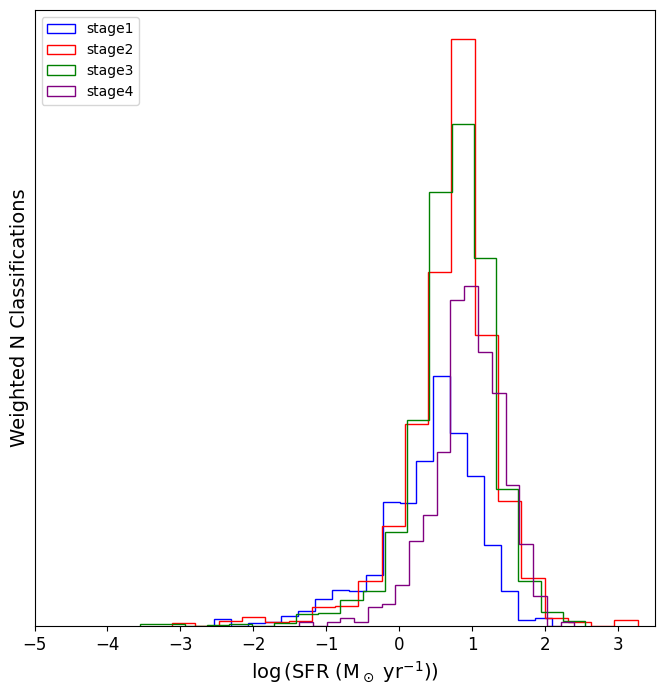

In [83]:
fig, ax = plt.subplots(figsize = (8,8))

ax.hist(sfr_s1, bins = 20, histtype='step', color='blue', weights=weights[0])
ax.hist(sfr_s2, bins = 20, histtype='step', color='red', weights=weights[1])
ax.hist(sfr_s3, bins = 20, histtype='step', color='green', weights=weights[2])
ax.hist(sfr_s4, bins = 20, histtype='step', color='purple',weights=weights[3])

# ax.hist(sfr_s1, bins = 20, histtype='step', color='blue', weights=weights[0], density=True)
# ax.hist(sfr_s2, bins = 20, histtype='step', color='red', weights=weights[1], density=True)
# ax.hist(sfr_s3, bins = 20, histtype='step', color='green', weights=weights[2], density=True)
# ax.hist(sfr_s4, bins = 20, histtype='step', color='purple',weights=weights[3], density=True)

plt.legend(['stage1','stage2','stage3','stage4'], loc='upper left')
plt.xlim([-5,3.5])
plt.xlabel('$\log$(SFR (M$_\odot$ yr$^{-1}$))', fontsize = 14)
plt.ylabel('Weighted N Classifications', fontsize = 14)
plt.tick_params(left = False, labelleft=False)
plt.savefig(f'{fig_folder}/sfr_dist.pdf', bbox_inches = 'tight')
plt.show()

In [84]:
def ks_weighted(arr1_all, arr2_all, w1_all, w2_all, return_dist=False):

    '''
    Given 2 arrays and their weights, returns Kolmogorov-Smirnov statistic and significance.

    This differs from the usual K-S test in that it computes a weighted K-S statistic and
    assumes the size of each sample is equal to the sum of the weights, not the length of
    the array. It's not exactly standard statistical practice to do this, so use with 
    caution, but it doesn't seem like a completely ridiculous idea, either.

        Parameters:
            arr1_all   (array): a data sample with values to be weighted by w1_all
            arr2_all   (array): a data sample with values to be weighted by w2_all
            w1_all     (array): weights for arr1_all
            w2_all     (array): weights for arr2_all
            return_dist (bool): True if the array of all K-S distances should be returned,
                                default is False (mostly only useful for debugging)

            Note: the arrays should be np.array() but other data types based on that should
                  work too, e.g. pd.Series, Astropy Table columns, etc. -- but if you get
                  an error on those, wrap your inputs with np.array().

        Returns:
            ks:     the weighted, 2-sided K-S statistic
            p_ks:   the p-value based on the weighted K-S statistic
            sig_ks: the significance level (in sigma) assuming p-values are distributed Normally

            if return_dist == True, also:
                dist_arr: array of KS-distances in raw format (sorted by increasing data sample value)
                          seriously this is not useful statistically, it's just for debugging

    '''

    # drop dead weight
    arr1 = np.array(arr1_all[w1_all > 0.0])
    arr2 = np.array(arr2_all[w2_all > 0.0])
    w1   = np.array(  w1_all[w1_all > 0.0])
    w2   = np.array(  w2_all[w2_all > 0.0])

    # get effective lengths of the weighted arrays
    n1 = np.sum(w1)
    n2 = np.sum(w2)
 
    # this is used below in the k-s calculation
    # (weighted sample sizes)
    ct = np.sqrt((n1+n2)/(n1*n2))

    # we want to sort the arrays, and the weights
    i1 = arr1.argsort()
    i2 = arr2.argsort()

    # sort arrays and weights in increasing order
    arr1_s = np.array(arr1[i1])
    w1_s   = np.array(  w1[i1])
    arr2_s = np.array(arr2[i2])
    w2_s   = np.array(  w2[i2])

    # make combined arrays but track which element comes from what, then sort them again
    both   = np.concatenate([arr1_s, arr2_s])
    both_w = np.concatenate([  w1_s,   w2_s])
    track  = np.concatenate([np.zeros(len(arr1_s), dtype=int), np.ones(len(arr2_s), dtype=int)])

    i_both   = both.argsort()
    both_s   = np.array(  both[i_both])
    both_w_s = np.array(both_w[i_both])
    track_s  = np.array( track[i_both])

    # go through array, once, computing the distance as we go, and track the max distance between cumulative curves
    # (which are both stored in the same array)
    # both cumulative curves start at 0 so the distance starts at 0
    # also cumulative curves always increase
    the_dist = 0.0
    dist_arr = np.zeros_like(both_s)
    max_dist = 0.0
    for j, this_which in enumerate(track_s):
        # the key here is the distance between curves goes up if array A has a new value,
        # and then if B has a new value that curve increases too so the curves get closer together
        # (the distance goes down).
        # it doesn't matter which is curve A and which is curve B, just that one increments 
        # and the other decrements.
        # if we were doing a regular K-S without weights, each new value for a given array changes
        # the distance between curves by 1 count. 
        # (with weighted, it only changes the distance by that object's weight.)
        # And also, these are cumulative curves, so each curve is divided by the total counts in that array
        # (which in the weighted case means the sum of the weights)
        # as a check, the distances should start at 0 and end at 0 (because the cumulative fractional
        # histograms both start at 0.0 and end at 1.0)
        if this_which == 0:
            the_dist += both_w_s[j]/n1
        else:
            the_dist -= both_w_s[j]/n2

        dist_arr[j] = the_dist
        if np.abs(the_dist) > max_dist:
            max_dist = np.abs(the_dist) 

    # the max dist over the whole cumulative curves is the K-S distance
    ks = max_dist
    # p-value (which also cares about the sample sizes)
    p_ks   = special.kolmogorov(float(ks)/float(ct))
    # scipy.stats.ks_2samp uses this instead?
    p_ksalt   = kstwobign.sf(((1./ct) + 0.12 + (0.11 * ct)) * ks)
    #print(p_ksalt)

    # what's the significance assuming a normal distribution? (1 = 1 sigma, 2. = 2 sigma, 3. = 3 sigma result etc.)
    sig_ks = special.erfcinv(p_ks)*np.sqrt(2.)



    if return_dist:
        return ks, p_ks, sig_ks, dist_arr
    else: 
        return ks, p_ks, sig_ks

In [85]:
def weight_dist(arr1, arr2, bins=None, return_bins=True, renorm=False):
    # this will take 2 arrays of values from 2 different samples
    # e.g. redshift distributions from 2 samples
    # and return weights for each value such that the weighted
    # distributions of each sample will match.

    # note the bins need to be the same for both datasets
    # so either supply 1 number or 1 array of bin edges
    # also if you have fully specified the bins you don't need them returned
    # but if we've had to figure them out, you do need them returned
    # if you want to make sure you aren't under-weighting (e.g. if a whole dataset is
    # much larger than the other so you might always be able select >1 object
    # in dataset 1 for each object in dataset 2) then you can re-normalise to make
    # sure the max weight of both datasets is 1
    # Note, if the distributions cross this won't make a difference

    # weight arrays
    w1 = np.zeros_like(arr1)
    w2 = np.zeros_like(arr2)

    # if bins not specified, guess at them ourselves
    if bins is None:
        minsize = np.amin([    len(arr1),     len(arr2)])
        themin  = np.amin([np.amin(arr1), np.amin(arr2)])
        themax  = np.amax([np.amax(arr1), np.amax(arr2)])

        # on average 5 data points per bin, but at least 3 bins pls, max value is last bin edge
        bins = np.linspace(themin, themax, int(np.amax([(minsize/5)+1, 3])), endpoint=True)

    else:
        pass
        # because the np.histogram function can deal with distinguishing between number of bins or specific bins itself
        # so we don't have to

    hist1, thebins = np.histogram(arr1, bins=bins)  # returns (counts_arr, bins_arr)
    # use the bins from hist1 to make hist2
    # note: for these purposes, any values of hist2 outside the minmax range of hist1 should have 0 weight
    # which is taken care of by the zeros_like initialisation of w1 and w2 above
    # so it's fine for them to be excluded below
    hist2, thebins = np.histogram(arr2, bins=thebins)

    # now step through the bins and assign weights
    for i_bin in range(len(thebins)-1):
        # zero-"index"ing these because they're indices and not values
        # and if I get them mixed up below I want this to error that there's no b2 or whatever
        b0 = thebins[i_bin]
        b1 = thebins[i_bin+1]

        count1 = hist1[i_bin]
        count2 = hist2[i_bin]

        # don't miss any values and don't double-count
        if i_bin == 0:
            in_bin1 = (arr1 >= b0) & (arr1 <= b1)
            in_bin2 = (arr2 >= b0) & (arr2 <= b1)
        else: 
            in_bin1 = (arr1 >  b0) & (arr1 <= b1)
            in_bin2 = (arr2 >  b0) & (arr2 <= b1)


        # don't divide by 0 in the rest of the if/else
        if (count1 == 0) | (count2 == 0):
            w1[in_bin1] = 0.0
            w2[in_bin2] = 0.0

        elif count1 < count2:
            # weight count2 values so the sum of wt2 in this bin equals count1
            # wt_fac will always be < 1
            wt_fac = float(count1)/float(count2)
            w1[in_bin1] = 1.0
            w2[in_bin2] = wt_fac

        else:
            # weight count1 values so the sum of wt1 in this bin equals count2
            # wt_fac will always be <= 1
            wt_fac = float(count2)/float(count1)
            w1[in_bin1] = wt_fac
            w2[in_bin2] = 1.0


    # now the weights should be determined
    # we can optionally re-normalise to make sure we are getting max value out of the datasets
    if renorm:
        if (np.sum(w1) > 0.00000) & (np.amax(w1) < 1.0):
            w1 /= np.amax(w1)

        if (np.sum(w2) > 0.00000) & (np.amax(w2) < 1.0):
            w2 /= np.amax(w2)


    if return_bins:
        return w1, w2, thebins 
    else: 
        return w1, w2

### Calculating Mass KS Test Weights

In [86]:
weights_s1, weights_s2 = weight_dist(masses_s1, masses_s2, bins = 20, renorm = False, return_bins = False)
weights_s1_s3, weights_s3 = weight_dist(masses_s1, masses_s3, bins = 20, renorm = False, return_bins = False)
weights_s1_s4, weights_s4 = weight_dist(masses_s1, masses_s4, bins = 20, renorm = False, return_bins = False)

In [87]:
ks_m_12, p_ks_m_12, sig_ks_12 = ks_weighted(masses_s1, masses_s2, weights_s1, weights_s2, return_dist=False)
ks_m_13, p_ks_m_13, sig_ks_13 = ks_weighted(masses_s1, masses_s3, weights_s1_s3, weights_s3, return_dist=False)
ks_m_14, p_ks_m_14, sig_ks_14 = ks_weighted(masses_s1, masses_s4, weights_s1_s4, weights_s4, return_dist=False)

In [88]:
weights_s2_s3, weights_s3 = weight_dist(masses_s2, masses_s3, bins = 20, renorm = False, return_bins = False)
weights_s2_s4, weights_s4 = weight_dist(masses_s2, masses_s4, bins = 20, renorm = False, return_bins = False)

In [89]:
ks_m_23, p_ks_m_23, sig_ks_23 = ks_weighted(masses_s2, masses_s3, weights_s2_s3, weights_s3, return_dist=False)
ks_m_24, p_ks_m_24, sig_ks_24 = ks_weighted(masses_s2, masses_s4, weights_s2_s4, weights_s4, return_dist=False)

In [90]:
weights_s3_s4, weights_s4 = weight_dist(masses_s3, masses_s4, bins = 20, renorm = False, return_bins = False)

In [91]:
ks_m_34, p_ks_m_34, sig_ks_34 = ks_weighted(masses_s3, masses_s4, weights_s3_s4, weights_s4, return_dist=False)

In [92]:
print(f'KS Score Mass between stages 1 and 2 = {ks_m_12}')
print(f'KS Score Mass between stages 1 and 3 = {ks_m_13}')
print(f'KS Score Mass between stages 1 and 4 = {ks_m_14}')
print(f'KS Score Mass between stages 2 and 3 = {ks_m_23}')
print(f'KS Score Mass between stages 2 and 4 = {ks_m_24}')
print(f'KS Score Mass between stages 3 and 4 = {ks_m_34}')
print(' ')
print(f'KS-test p-value Mass between stages 1 and 2 = {p_ks_m_12}')
print(f'KS-test p-value Mass between stages 1 and 3 = {p_ks_m_13}')
print(f'KS-test p-value Mass between stages 1 and 4 = {p_ks_m_14}')
print(f'KS-test p-value Mass between stages 2 and 3 = {p_ks_m_23}')
print(f'KS-test p-value Mass between stages 2 and 4 = {p_ks_m_24}')
print(f'KS-test p-value Mass between stages 3 and 4 = {p_ks_m_34}')
print(' ')
print(f'KS-test significance Mass between stages 1 and 2 = {sig_ks_14}')
print(f'KS-test significance Mass between stages 1 and 3 = {sig_ks_24}')
print(f'KS-test significance Mass between stages 1 and 4 = {sig_ks_34}')
print(f'KS-test significance Mass between stages 2 and 3 = {sig_ks_23}')
print(f'KS-test significance Mass between stages 2 and 4 = {sig_ks_24}')
print(f'KS-test significance Mass between stages 3 and 4 = {sig_ks_34}')

KS Score Mass between stages 1 and 2 = 0.017693981145757834
KS Score Mass between stages 1 and 3 = 0.01846934791097231
KS Score Mass between stages 1 and 4 = 0.021688675470188074
KS Score Mass between stages 2 and 3 = 0.013587775639390627
KS Score Mass between stages 2 and 4 = 0.013658988308832054
KS Score Mass between stages 3 and 4 = 0.014531277689172417
 
KS-test p-value Mass between stages 1 and 2 = 0.9999999792559664
KS-test p-value Mass between stages 1 and 3 = 0.999999897115249
KS-test p-value Mass between stages 1 and 4 = 0.999996402320619
KS-test p-value Mass between stages 2 and 3 = 0.9999999394083171
KS-test p-value Mass between stages 2 and 4 = 0.9999999999789209
KS-test p-value Mass between stages 3 and 4 = 0.9999999986199302
 
KS-test significance Mass between stages 1 and 2 = 4.509022429703716e-06
KS-test significance Mass between stages 1 and 3 = 2.6418782202694023e-11
KS-test significance Mass between stages 1 and 4 = 1.7296610361766793e-09
KS-test significance Mass be

### Calculating SFR KS Test Weights

In [93]:
weights_s1, weights_s2 = weight_dist(masses_s1, masses_s2, bins = 20, renorm = False, return_bins = False)
weights_s1_s3, weights_s3 = weight_dist(masses_s1, masses_s3, bins = 20, renorm = False, return_bins = False)
weights_s1_s4, weights_s4 = weight_dist(masses_s1, masses_s4, bins = 20, renorm = False, return_bins = False)

In [94]:
ks_s_12, p_ks_s_12, sig_ks_s_12 = ks_weighted(sfr_s1, sfr_s2, weights_s1, weights_s2, return_dist=False)
ks_s_13, p_ks_s_13, sig_ks_s_13 = ks_weighted(sfr_s1, sfr_s3, weights_s1_s3, weights_s3, return_dist=False)
ks_s_14, p_ks_s_14, sig_ks_s_14 = ks_weighted(sfr_s1, sfr_s4, weights_s1_s4, weights_s4, return_dist=False)

In [95]:
weights_s2_s3, weights_s3 = weight_dist(masses_s2, masses_s3, bins = 20, renorm = False, return_bins = False)
weights_s2_s4, weights_s4 = weight_dist(masses_s2, masses_s4, bins = 20, renorm = False, return_bins = False)

In [96]:
ks_s_23, p_ks_s_23, sig_ks_s_23 = ks_weighted(sfr_s2, sfr_s3, weights_s2_s3, weights_s3, return_dist=False)
ks_s_24, p_ks_s_24, sig_ks_s_24 = ks_weighted(sfr_s2, sfr_s4, weights_s2_s4, weights_s4, return_dist=False)

In [97]:
weights_s3_s4, weights_s4 = weight_dist(masses_s3, masses_s4, bins = 20, renorm = False, return_bins = False)

In [98]:
ks_s_34, p_ks_s_34, sig_ks_s_34 = ks_weighted(sfr_s3, sfr_s4, weights_s3_s4, weights_s4, return_dist=False)

In [99]:
print(f'KS-test SFR between stages 1 and 2 = {p_ks_s_12}')
print(f'KS-test SFR between stages 1 and 3 = {p_ks_s_13}')
print(f'KS-test SFR between stages 1 and 4 = {p_ks_s_14}')
print(f'KS-test SFR between samples 2 and 3 = {p_ks_s_23}')
print(f'KS-test SFR between stages 2 and 4 = {p_ks_s_24}')
print(f'KS-test SFR between stages 3 and 4 = {p_ks_s_34}')
print(' ')
print(f'KS-test p-value Mass between stages 1 and 2 = {p_ks_s_12}')
print(f'KS-test p-value Mass between stages 1 and 3 = {p_ks_s_13}')
print(f'KS-test p-value Mass between stages 1 and 4 = {p_ks_s_14}')
print(f'KS-test p-value Mass between stages 2 and 3 = {p_ks_s_23}')
print(f'KS-test p-value Mass between stages 2 and 4 = {p_ks_s_24}')
print(f'KS-test p-value Mass between stages 3 and 4 = {p_ks_s_34}')
print(' ')
print(f'KS-test significance Mass between stages 1 and 2 = {sig_ks_s_12}')
print(f'KS-test significance Mass between stages 1 and 3 = {sig_ks_s_13}')
print(f'KS-test significance Mass between stages 1 and 4 = {sig_ks_s_14}')
print(f'KS-test significance Mass between stages 2 and 3 = {sig_ks_s_23}')
print(f'KS-test significance Mass between stages 2 and 4 = {sig_ks_s_24}')
print(f'KS-test significance Mass between stages 3 and 4 = {sig_ks_s_34}')

KS-test SFR between stages 1 and 2 = 3.6652157112356e-09
KS-test SFR between stages 1 and 3 = 2.0216257157133566e-09
KS-test SFR between stages 1 and 4 = 4.8644921220947704e-24
KS-test SFR between samples 2 and 3 = 0.674566984338926
KS-test SFR between stages 2 and 4 = 2.9532876165857885e-07
KS-test SFR between stages 3 and 4 = 1.138592515132913e-07
 
KS-test p-value Mass between stages 1 and 2 = 3.6652157112356e-09
KS-test p-value Mass between stages 1 and 3 = 2.0216257157133566e-09
KS-test p-value Mass between stages 1 and 4 = 4.8644921220947704e-24
KS-test p-value Mass between stages 2 and 3 = 0.674566984338926
KS-test p-value Mass between stages 2 and 4 = 2.9532876165857885e-07
KS-test p-value Mass between stages 3 and 4 = 1.138592515132913e-07
 
KS-test significance Mass between stages 1 and 2 = 5.898634750675952
KS-test significance Mass between stages 1 and 3 = 5.996059823866986
KS-test significance Mass between stages 1 and 4 = 10.112464511865086
KS-test significance Mass betwe

### Applying an Anderson-Darling Test
This just compares the results to a normal function and checks if they are from that distribution. Not 100% sure what this achieves yet.

In [100]:
ad_m1, ad_crit_m1, ad_sig_m1 = anderson(masses_s1, dist = 'norm')
ad_m2, ad_crit_m2, ad_sig_m2 = anderson(masses_s2, dist = 'norm')
ad_m3, ad_crit_m3, ad_sig_m3 = anderson(masses_s3, dist = 'norm')
ad_m4, ad_crit_m4, ad_sig_m4 = anderson(masses_s4, dist = 'norm')

In [101]:
def checking_ad_stat(stat, crit_vals):
    for i in crit_vals:
        if stat < i:
            return 'Failed'
    
    return 'Passed'

In [102]:
m1_ad_check = checking_ad_stat(ad_m1, ad_crit_m1)
m2_ad_check = checking_ad_stat(ad_m2, ad_crit_m2)
m3_ad_check = checking_ad_stat(ad_m3, ad_crit_m3)
m4_ad_check = checking_ad_stat(ad_m4, ad_crit_m4)

In [103]:
print(f'M1 distribution {m1_ad_check} the Anderson-Darling Test.')
print(f'M2 distribution {m2_ad_check} the Anderson-Darling Test.')
print(f'M3 distribution {m3_ad_check} the Anderson-Darling Test.')
print(f'M4 distribution {m4_ad_check} the Anderson-Darling Test.')

M1 distribution Passed the Anderson-Darling Test.
M2 distribution Passed the Anderson-Darling Test.
M3 distribution Passed the Anderson-Darling Test.
M4 distribution Passed the Anderson-Darling Test.


In [104]:
ad_m4

5.225024501863118

In [105]:
ad_crit_m4

array([0.572, 0.651, 0.781, 0.911, 1.084])

In [106]:
ad_sf1, ad_crit_sf1, ad_sig_sf1 = anderson(sfr_s1, dist = 'norm')
ad_sf2, ad_crit_sf2, ad_sig_sf2 = anderson(sfr_s2, dist = 'norm')
ad_sf3, ad_crit_sf3, ad_sig_sf3 = anderson(sfr_s3, dist = 'norm')
ad_sf4, ad_crit_sf4, ad_sig_sf4 = anderson(sfr_s4, dist = 'norm')

In [107]:
m1_ad_check = checking_ad_stat(ad_sf1, ad_crit_sf1)
m2_ad_check = checking_ad_stat(ad_sf2, ad_crit_sf2)
m3_ad_check = checking_ad_stat(ad_sf3, ad_crit_sf3)
m4_ad_check = checking_ad_stat(ad_sf4, ad_crit_sf4)

In [108]:
print(f'SF1 distribution {m1_ad_check} the Anderson-Darling Test.')
print(f'SF2 distribution {m2_ad_check} the Anderson-Darling Test.')
print(f'SF3 distribution {m3_ad_check} the Anderson-Darling Test.')
print(f'SF4 distribution {m4_ad_check} the Anderson-Darling Test.')

SF1 distribution Passed the Anderson-Darling Test.
SF2 distribution Passed the Anderson-Darling Test.
SF3 distribution Passed the Anderson-Darling Test.
SF4 distribution Passed the Anderson-Darling Test.


### Conclusions
The mass distributions are all pretty much identical under a KS test. However, the star formation rate distributions are wildly different between each, with the exception of at stage 2 and 3. This implies that whereever you are in the interaction - at apocentre or at pericentre - the process by which star formation is increased is well in swing. It is then very different for those galaxies at stage 4.

### Using Aird et al. 2019

In [109]:
df_sfrs = df_noextra[['ORyanID_23', 'ID', 'category', 'ez_sfr', 'lp_mass_best', 'ez_z_phot', 'lp_zBEST']]

In [110]:
def picking_z(ez_z, lp_z):
    if np.isnan(ez_z):
        if not np.isnan(lp_z):
            return lp_z
        else:
            return np.nan
    
    if np.isnan(lp_z):
        if not np.isnan(ez_z):
            return ez_z
        else:
            return np.nan
    
    if lp_z < ez_z:
        return lp_z
    elif ez_z <= lp_z:
        return ez_z
    else:
        return 'what'

In [111]:
df_z = (
    df_sfrs
    .assign(redshift = df_sfrs.apply(lambda row: picking_z(row.ez_z_phot, row.lp_zBEST), axis = 1))
    .drop(columns = ['ez_z_phot', 'lp_zBEST'])
)

In [112]:
df_ms_sfr = (
    df_z
    .assign(ms_sfr = df_z.apply(lambda row: -7.6 + (0.76 * row.lp_mass_best) + 2.95 * np.log10(1 + row.redshift), axis = 1))
)

In [113]:
df_ms_sfr

,ORyanID_23,ID,category,ez_sfr,lp_mass_best,redshift,ms_sfr
0,4000705532455,816891,stage4,0.589695,9.28590,0.519525,-0.006678
1,4000705533383,860686,stage3,1.609304,10.44862,1.124400,1.306298
3,4000705540034,1304538,stage3,1.101499,9.96798,1.024009,0.878992
4,4000705540064,1310001,stage3,1.083541,10.41827,0.486400,0.825686
5,4000705540104,1308927,stage3,1.198906,10.03523,0.695800,0.703430
...,...,...,...,...,...,...,...
3338,6000536013605,1203157,stage3,0.975221,10.25633,0.774100,0.929296
3340,4000859744022,1385125,stage1,2.005615,11.08258,1.021056,1.724217
3342,4001051778929,1293175,stage1,0.712900,9.82151,0.360587,0.258840
3344,4001185627710,1295082,stage2,0.866149,9.66478,0.741689,0.456096


In [114]:
def finding_sfr(log_sfr, log_sfr_ms):
    sfr = 10 ** log_sfr
    sfr_ms = 10 ** log_sfr_ms
    frac = sfr / sfr_ms
    return np.log10(frac)

In [115]:
df_comp = (
    df_ms_sfr
    .assign(sfr_sfr_ms = df_ms_sfr.apply(lambda row: finding_sfr(row.ez_sfr, row.ms_sfr), axis = 1))
)
df_comp

,ORyanID_23,ID,category,ez_sfr,lp_mass_best,redshift,ms_sfr,sfr_sfr_ms
0,4000705532455,816891,stage4,0.589695,9.28590,0.519525,-0.006678,0.596373
1,4000705533383,860686,stage3,1.609304,10.44862,1.124400,1.306298,0.303006
3,4000705540034,1304538,stage3,1.101499,9.96798,1.024009,0.878992,0.222507
4,4000705540064,1310001,stage3,1.083541,10.41827,0.486400,0.825686,0.257855
5,4000705540104,1308927,stage3,1.198906,10.03523,0.695800,0.703430,0.495476
...,...,...,...,...,...,...,...,...
3338,6000536013605,1203157,stage3,0.975221,10.25633,0.774100,0.929296,0.045924
3340,4000859744022,1385125,stage1,2.005615,11.08258,1.021056,1.724217,0.281398
3342,4001051778929,1293175,stage1,0.712900,9.82151,0.360587,0.258840,0.454060
3344,4001185627710,1295082,stage2,0.866149,9.66478,0.741689,0.456096,0.410052


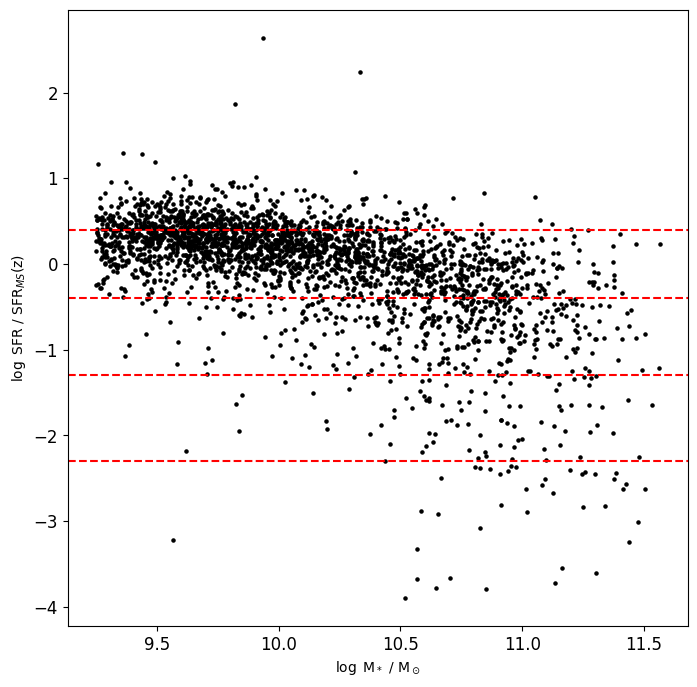

In [116]:
df_comp.plot.scatter(
    x = 'lp_mass_best',
    y = 'sfr_sfr_ms',
    s = 5,
    color = 'black',
    figsize = (8,8),
    xlabel = '$\log$ M$_*$ / M$_\odot$',
    ylabel = '$\log$ SFR / SFR$_{MS}$(z)',
)
plt.axhline(0.4, color='red', linestyle='--')
plt.axhline(-0.4, color = 'red', linestyle='--')
plt.axhline(-1.3, color = 'red', linestyle = '--')
plt.axhline(-2.3, color = 'red', linestyle='--')

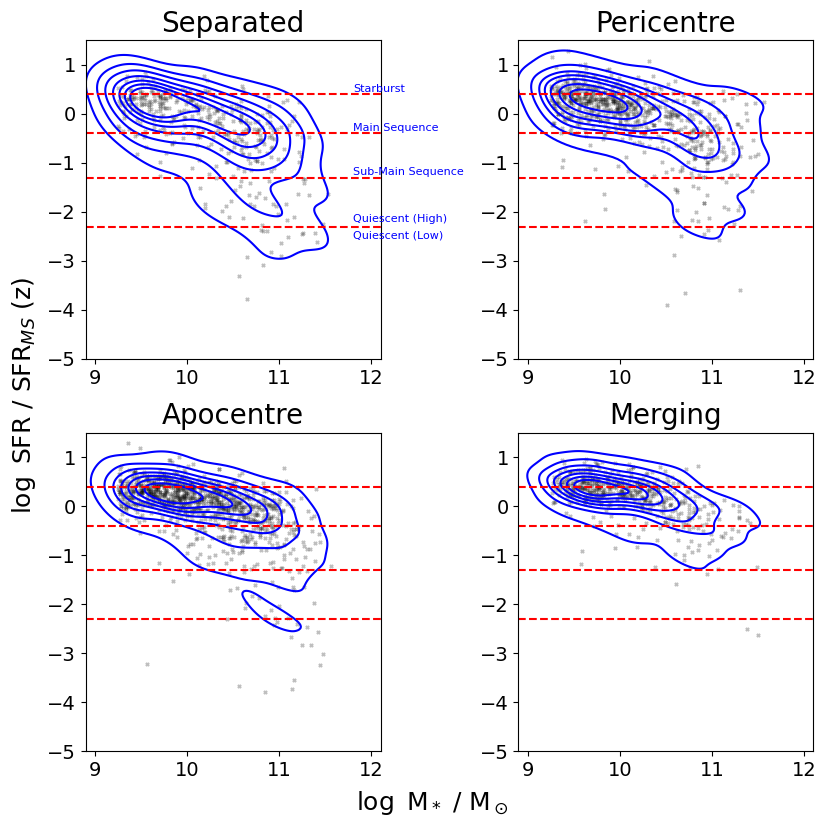

In [117]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))
counter = 1
for i in range(2):
    for j in range(2):
        df_comp.query(f'category == "stage{counter}"').plot.scatter(
            x = 'lp_mass_best',
            y = 'sfr_sfr_ms',
            s = 5,
            marker = 'x',
            alpha = 0.25,
            color = 'black',
            ax = ax[i,j],
            # figsize = (8,8),
            xlabel = '',
            ylabel = '',
            xlim = [8.9, 12.1],
            ylim = [-5, 1.5],
            fontsize = 14,
        )
        ax[i,j].set_title(stage_list[counter-1], fontsize = 20)
        x = np.array(df_comp.query(f'category == "stage{counter}"').lp_mass_best)
        y = np.array(df_comp.query(f'category == "stage{counter}"').sfr_sfr_ms)
        sns.kdeplot(x=x,y=y, ax=ax[i,j], thresh = 0.05, levels=8, color='blue')
        
        ax[i,j].axhline(0.4, color='red', linestyle='--')
        ax[i,j].axhline(-0.4, color = 'red', linestyle='--')
        ax[i,j].axhline(-1.3, color = 'red', linestyle = '--')
        ax[i,j].axhline(-2.3, color = 'red', linestyle='--')
        if counter == 1:
            ax[i,j].text(11.8, 0.45, 'Starburst', fontsize = 8, color='blue')
            ax[i,j].text(11.8, -0.35, 'Main Sequence', fontsize = 8, color='blue')
            ax[i,j].text(11.8, -1.25, 'Sub-Main Sequence', fontsize = 8, color='blue')
            ax[i,j].text(11.8, -2.20, 'Quiescent (High)', fontsize = 8, color='blue')
            ax[i,j].text(11.8, -2.55, 'Quiescent (Low)', fontsize = 8, color='blue')
        
        
        counter += 1
fig.text(0.5, -0.01, '$\log$ M$_*$ / M$_\odot$', ha='center', va='center', fontsize = 18)
fig.text(-0.01, 0.5, '$\log$ SFR / SFR$_{MS}$ (z)', ha='center', va='center', rotation='vertical', fontsize = 18)
fig.tight_layout()
fig.savefig(f'{fig_folder}/sfr-clsf-dist.pdf', bbox_inches='tight')
plt.show()

### Building Above with Histograms

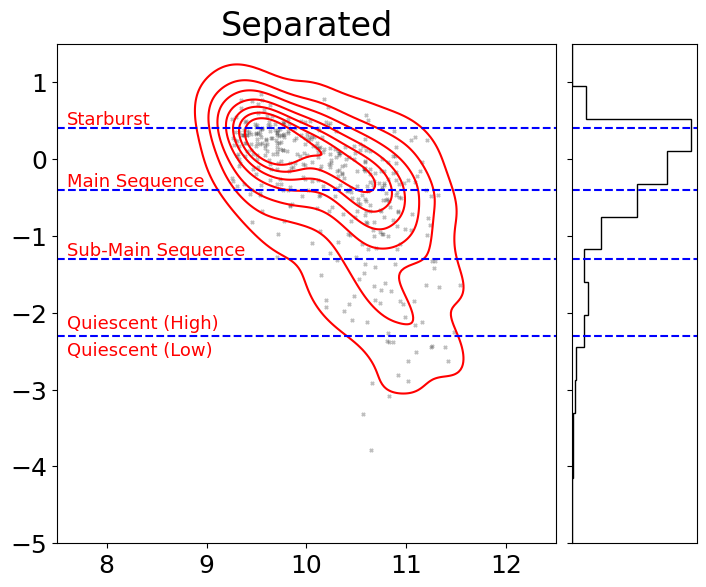

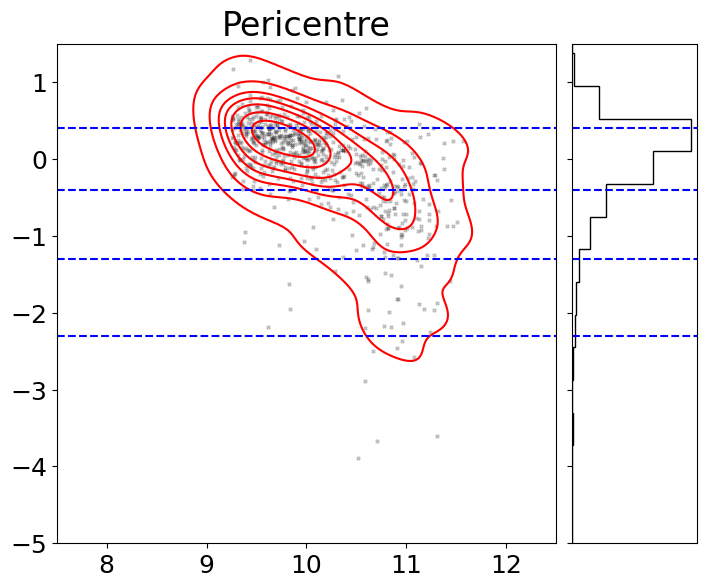

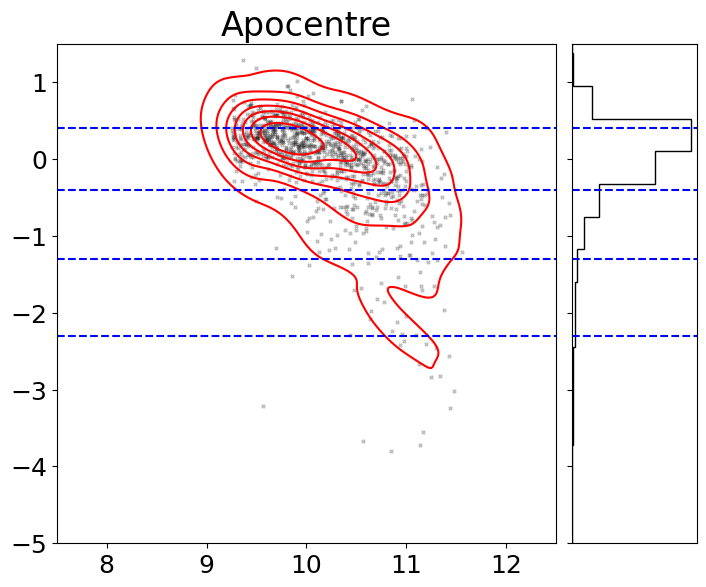

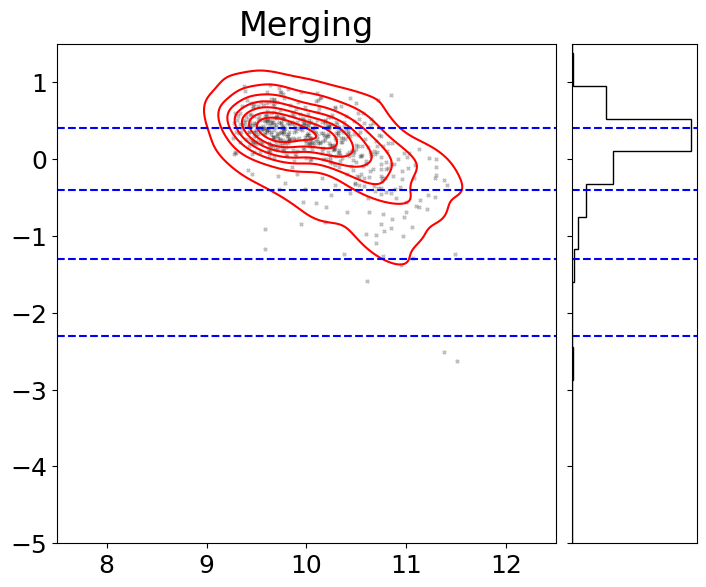

In [125]:
stages = ['Separated', 'Pericentre', 'Apocentre', 'Merging']
for i in range(4):
    fig = plt.figure(figsize = (8,8))
    gs = fig.add_gridspec(2,2,width_ratios=(4,1), height_ratios=(1,4), left = 0.1, right = 0.9, bottom = 0.1, top = 0.9, wspace=0.05, hspace=0.05)
    ax = fig.add_subplot(gs[1,0])
    ax_hist = fig.add_subplot(gs[1,1], sharey=ax)
    df_comp.query(f'category == "stage{i+1}"').plot.scatter(
            x = 'lp_mass_best',
            y = 'sfr_sfr_ms',
            s = 5,
            marker = 'x',
            alpha = 0.25,
            color = 'black',
            ax = ax,
            # figsize = (8,8),
            xlabel = '',
            ylabel = '',
            xlim = [7.5, 12.5],
            ylim = [-5, 1.5],
            fontsize = 18,
        )
    
    ax.set_title(f'{stages[i]}', fontsize = 24)
    
    x = np.array(df_comp.query(f'category == "stage{i+1}"').lp_mass_best)
    y = np.array(df_comp.query(f'category == "stage{i+1}"').sfr_sfr_ms)
    sns.kdeplot(x=x,y=y, ax=ax, thresh = 0.04, levels=8, color='red')

    ax_hist.hist(
        df_comp.query(f'category == "stage{i+1}"').sfr_sfr_ms,
        bins=20,
        histtype='step',
        color='black',
        orientation='horizontal',
        density = True,
        range = [-5, 3.5],
    )
    
    ax_hist.xaxis.set_tick_params(labelbottom=False)
    # ax_hist.yaxis.set_tick_params(labelbottom=False)
    ax_hist.set_xticks([])
    # ax_hist.set_yticks([])

    ax_hist.axhline(0.4, color='blue', linestyle='--')
    ax_hist.axhline(-0.4, color = 'blue', linestyle='--')
    ax_hist.axhline(-1.3, color = 'blue', linestyle = '--')
    ax_hist.axhline(-2.3, color = 'blue', linestyle='--')
    
    ax.axhline(0.4, color='blue', linestyle='--')
    ax.axhline(-0.4, color = 'blue', linestyle='--')
    ax.axhline(-1.3, color = 'blue', linestyle = '--')
    ax.axhline(-2.3, color = 'blue', linestyle='--')
    
    if i == 0:
        ax.text(7.6, 0.45, 'Starburst', fontsize = 13, color='red')
        ax.text(7.6, -0.35, 'Main Sequence', fontsize = 13, color='red')
        ax.text(7.6, -1.25, 'Sub-Main Sequence', fontsize = 13, color='red')
        ax.text(7.6, -2.20, 'Quiescent (High)', fontsize = 13, color='red')
        ax.text(7.6, -2.55, 'Quiescent (Low)', fontsize = 13, color='red')
            
    fig.savefig(f'{fig_folder}/tmp/sfms-stage-{i+1}.jpeg', bbox_inches = 'tight', dpi = 720)    

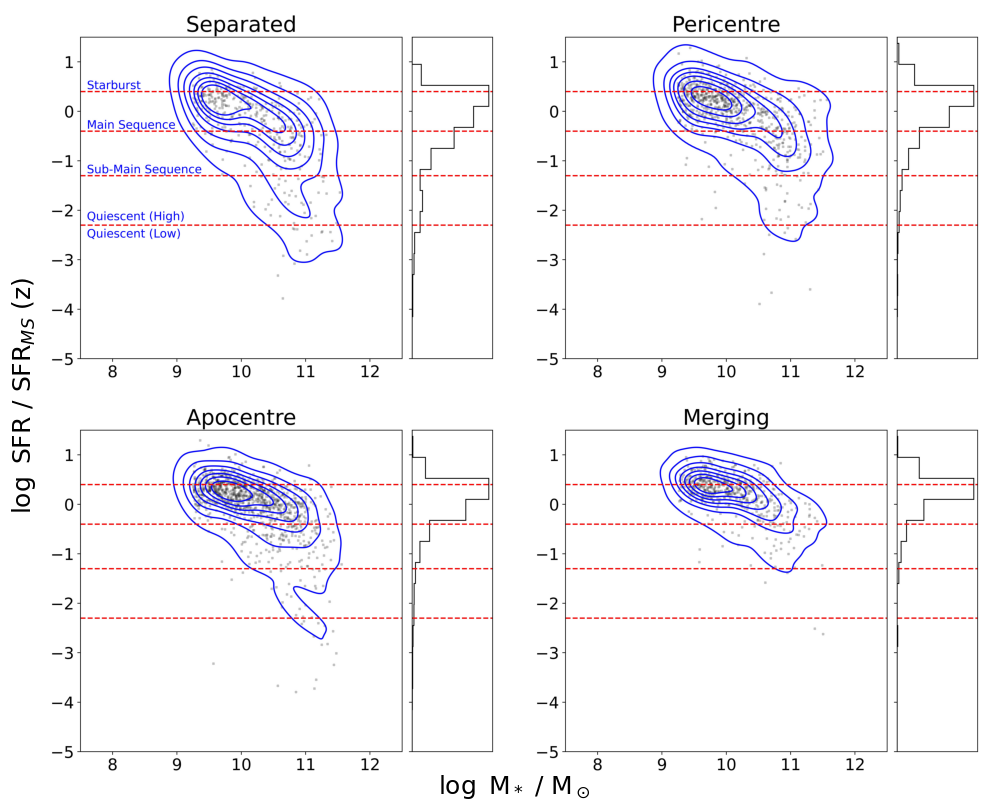

In [126]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))
counter = 1
for i in range(2):
    for j in range(2):
        im = cv.imread(f'{fig_folder}/tmp/sfms-stage-{counter}.jpeg')
        ax[i,j].imshow(im)
        ax[i,j].axis('off')
        counter += 1
        
fig.text(0.5, 0.01, '$\log$ M$_*$ / M$_\odot$', ha='center', va='center', fontsize = 18)
fig.text(0.01, 0.5, '$\log$ SFR / SFR$_{MS}$ (z)', ha='center', va='center', rotation='vertical', fontsize = 18)
fig.tight_layout()
fig.savefig(f'{fig_folder}/sfr-clsf-dist.pdf', bbox_inches='tight', dpi = 720)

In [127]:
def categorising_sfrs(log_sfr_sfr_ms):
    if log_sfr_sfr_ms > 0.4:
        return 'starburst'
    elif log_sfr_sfr_ms < 0.4 and log_sfr_sfr_ms > -0.4:
        return 'Main Sequence'
    elif log_sfr_sfr_ms < -0.4 and log_sfr_sfr_ms > -1.3:
        return 'Sub Main Sequence'
    elif log_sfr_sfr_ms < -1.3 and log_sfr_sfr_ms > -2.3:
        return 'Quiescent (High)'
    elif log_sfr_sfr_ms < -2.3:
        return 'Quiescent (Low)'
    else:
        print('Huh?')
        sys.exit()

In [128]:
df_sfr_clsf = (
    df_comp
    .assign(sfr_category = df_comp.sfr_sfr_ms.apply(lambda x: categorising_sfrs(x)))
)

In [129]:
values = df_sfr_clsf.sfr_category.value_counts()

In [130]:
values

Main Sequence        1614
starburst             537
Sub Main Sequence     375
Quiescent (High)       89
Quiescent (Low)        40
Name: sfr_category, dtype: int64

In [131]:
x = ['SB', 'MS', 'S-MS','Q(High)','Q(Low)']
y = [values['starburst'], values['Main Sequence'], values['Sub Main Sequence'], values['Quiescent (High)'], values['Quiescent (Low)']]

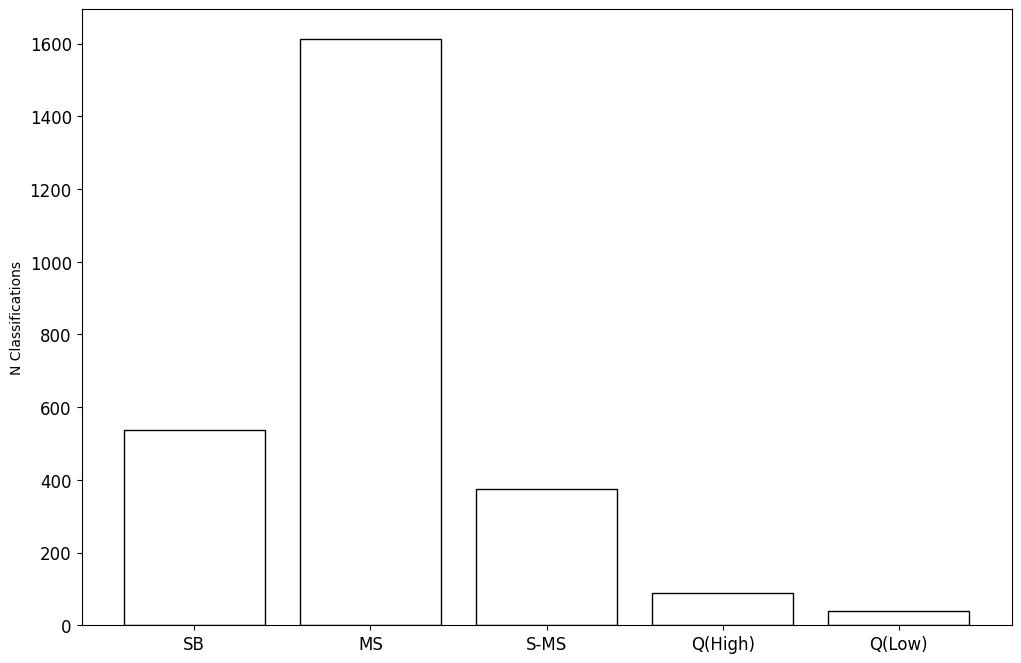

In [132]:
plt.figure(figsize = (12,8))
plt.bar(x, y, fill = False)
plt.ylabel('N Classifications')
# plt.text(-0.5, 1550, f'N$_t$ = {df_merg.category.value_counts().sum()}')
plt.show()

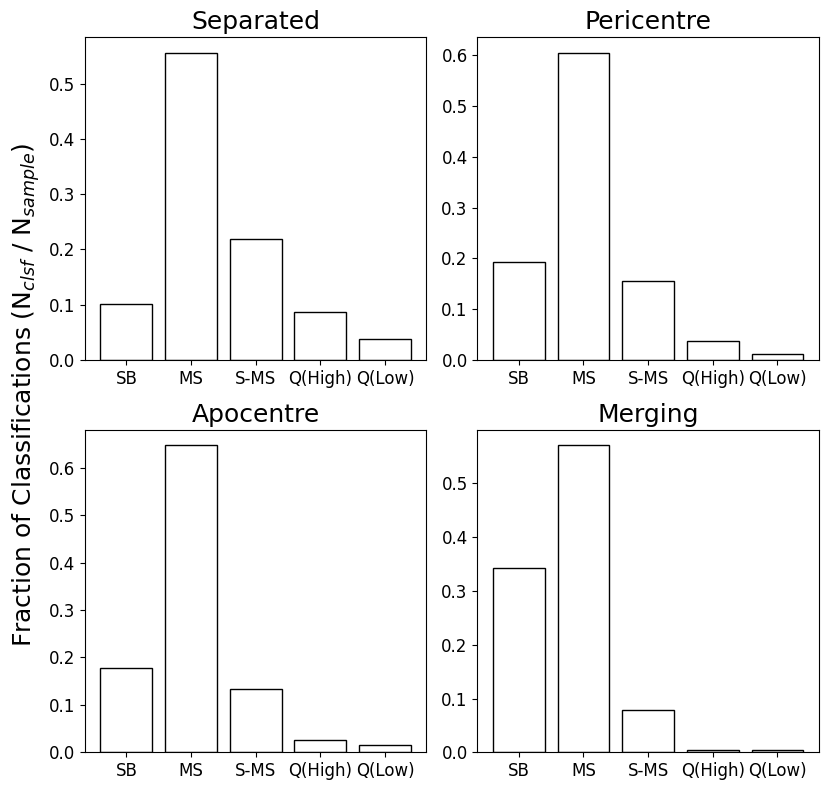

In [133]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))
counter = 1
x = ['SB', 'MS', 'S-MS','Q(High)','Q(Low)']
for i in range(2):
    for j in range(2):
        values = df_sfr_clsf.query(f'category == "stage{counter}"').sfr_category.value_counts()
        y = [values['starburst'], values['Main Sequence'], values['Sub Main Sequence'], values['Quiescent (High)'], values['Quiescent (Low)']]
        n_clsfs = sum(y)
        y = y / n_clsfs
        
        ax[i,j].bar(x, y, fill = False)
        ax[i,j].set_title(f'{stage_list[counter-1]}', fontsize = 18)
        # plt.text(-0.5, 1550, f'N$_t$ = {df_merg.category.value_counts().sum()}')
        # plt.show()
        
        
        counter += 1
fig.text(-0.01, 0.5, 'Fraction of Classifications (N$_{clsf}$ / N$_{sample}$)', ha='center', va='center', rotation='vertical', fontsize = 18)
fig.tight_layout()
fig.savefig(f'{fig_folder}/sfr-clsf-bar.pdf', bbox_inches = 'tight')
plt.show()

### Looking at Projected Separations

In [134]:
df_prim_sec_id = pd.read_csv(f'{combine_fold}/primary-secondary-z-checked.csv', index_col = 0)
df_prim_sec_id

,ORyan23_ID_1,ID_Prim,prim_cat,Prim_RA,Prim_Dec,lp_mass_best_prim,ez_sfr_prim,prim_coords,z_prim,ORyan23_ID_2,ID_Sec,sec_cat,Sec_RA,Sec_Dec,lp_mass_best_sec,ez_sfr_sec,sec_coords,z_sec,z_diff
0,4000705547180,1266054,stage1,150.320392,2.620598,10.60467,0.997192,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.995600,4000705547180,1264241,stage1,150.319695,2.618060,10.53484,1.474177,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.982027,0.013573
1,4000706649921,840582,stage3,150.061821,2.218277,10.84630,1.745799,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",1.152400,4000706649921,844303,stage3,150.059115,2.219933,11.05237,2.547000,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",1.118725,0.033675
2,4000707047768,246358,stage1,150.200064,1.632469,10.63540,0.144319,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.227065,4000707047768,246327,stage1,150.197217,1.631803,10.53981,0.066335,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.204897,0.022168
3,4000711650343,1082084,stage3,149.956640,2.441887,9.88246,-0.218701,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.318100,4000711650343,1084532,stage3,149.957283,2.438351,10.47155,-0.958259,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.357000,-0.038900
4,4000711824674,1482542,stage3,150.682460,2.832526,9.36047,1.463963,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.668730,4000711824674,1482412,stage3,150.683004,2.832839,10.10035,0.234238,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.732343,-0.063613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,4001028895751,627906,stage2,150.133804,2.020077,11.30014,0.982440,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.964800,4001028895751,625664,stage2,150.134452,2.019575,10.01168,1.227766,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.953100,0.011700
374,4001031492536,849937,stage3,150.423229,2.220250,11.34001,-1.098582,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.736700,4001031492536,847121,stage3,150.423166,2.223189,9.80205,1.504900,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.741400,-0.004700
375,4001031962582,1430670,stage1,150.088831,2.778976,10.48227,-0.123495,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.232038,4001031962582,1431797,stage1,150.087899,2.779759,9.94333,0.712074,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.222589,0.009449
376,4001037562450,1041423,stage3,149.522797,2.402268,9.93052,1.070738,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.832700,4001037562450,1044549,stage3,149.524495,2.402985,11.04360,1.528921,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.883414,-0.050714


In [135]:
df_prim_sfr_frac = (
    df_prim_sec_id
    .merge(df_comp[['ID', 'sfr_sfr_ms']], left_on = 'ID_Prim', right_on = 'ID', how = 'left')
    .drop(columns = ['ID'])
    .rename(columns = {'sfr_sfr_ms' : 'prim_sfr_ms'})
)

In [136]:
df_prim_sec_frac = (
    df_prim_sfr_frac
    .merge(df_comp[['ID', 'sfr_sfr_ms']], left_on = 'ID_Sec', right_on = 'ID', how = 'left')
    .drop(columns = ['ID'])
    .rename(columns = {'sfr_sfr_ms' : 'sec_sfr_ms'})
)

In [137]:
df_prim_sec_red = df_prim_sec_frac[['ID_Prim', 'ID_Sec', 'lp_mass_best_prim', 'lp_mass_best_sec', 'ez_sfr_prim', 'ez_sfr_sec', 'Prim_RA', 'Prim_Dec', 'Sec_RA', 'Sec_Dec', 'sec_coords', 'z_prim', 'z_sec', 'prim_sfr_ms', 'sec_sfr_ms', 'prim_cat', 'sec_cat']]

In [138]:
def calc_seps(prim_ra, prim_dec, sec_ra, sec_dec, z1, z2, cosmo):
    z = (z1 + z2) / 2
    
    prim_coord = SkyCoord(ra = prim_ra * u.deg, dec = prim_dec * u.deg, frame = 'fk5')
    sec_coord = SkyCoord(ra = sec_ra * u.deg, dec = sec_dec * u.deg, frame = 'fk5')
    
    sep = (prim_coord.separation(sec_coord)).to(u.arcmin)
    
    conversion = cosmo.kpc_proper_per_arcmin(z)
    
    proj_dist = (sep * conversion) / u.kpc
    
    return proj_dist

In [139]:
cosmo = FlatLambdaCDM(H0=70.0 * u.km / (u.Mpc * u.s), Om0=0.3, Tcmb0=2.725 * u.K)

In [140]:
df_proj = (
    df_prim_sec_red
    .assign(proj_seps = df_prim_sec_red.apply(lambda row: np.float64(calc_seps(row.Prim_RA, row.Prim_Dec, row.Sec_RA, row.Sec_Dec, row.z_prim, row.z_sec, cosmo)), axis = 1))
)
df_proj

,ID_Prim,ID_Sec,lp_mass_best_prim,lp_mass_best_sec,ez_sfr_prim,ez_sfr_sec,Prim_RA,Prim_Dec,Sec_RA,Sec_Dec,sec_coords,z_prim,z_sec,prim_sfr_ms,sec_sfr_ms,prim_cat,sec_cat,proj_seps
0,1266054,1264241,10.60467,10.53484,0.997192,1.474177,150.320392,2.620598,150.319695,2.618060,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.995600,0.982027,-0.347574,0.191225,stage1,stage1,75.670970
1,840582,844303,10.84630,11.05237,1.745799,2.547000,150.061821,2.218277,150.059115,2.219933,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",1.152400,1.118725,0.120488,0.785278,stage3,stage3,93.820626
2,246358,246327,10.63540,10.53981,0.144319,0.066335,150.200064,1.632469,150.197217,1.631803,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.227065,0.204897,-0.600744,-0.582722,stage1,stage1,36.848274
3,1082084,1084532,9.88246,10.47155,-0.218701,-0.958259,149.956640,2.441887,149.957283,2.438351,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.318100,0.357000,-0.483218,-1.707748,stage3,stage3,62.400421
4,1482542,1482412,9.36047,10.10035,1.463963,0.234238,150.682460,2.832526,150.683004,2.832839,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.668730,0.732343,1.293967,-0.545998,stage3,stage3,16.151779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,627906,625664,11.30014,10.01168,0.982440,1.227766,150.133804,2.020077,150.134452,2.019575,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.964800,0.953100,-0.870955,0.361252,stage2,stage2,23.355685
361,849937,847121,11.34001,9.80205,-1.098582,1.504900,150.423229,2.220250,150.423166,2.223189,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.736700,0.741400,-2.824178,0.944692,stage3,stage3,77.204246
362,1430670,1431797,10.48227,9.94333,-0.123495,0.712074,150.088831,2.778976,150.087899,2.779759,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.232038,0.222589,-0.757361,0.497667,stage1,stage1,15.952583
363,1041423,1044549,9.93052,11.04360,1.070738,1.528921,149.522797,2.402268,149.524495,2.402985,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",0.832700,0.883414,0.347423,-0.075305,stage3,stage3,50.931174


In [141]:
bins = [0, 25, 50, 75, 100, 150]

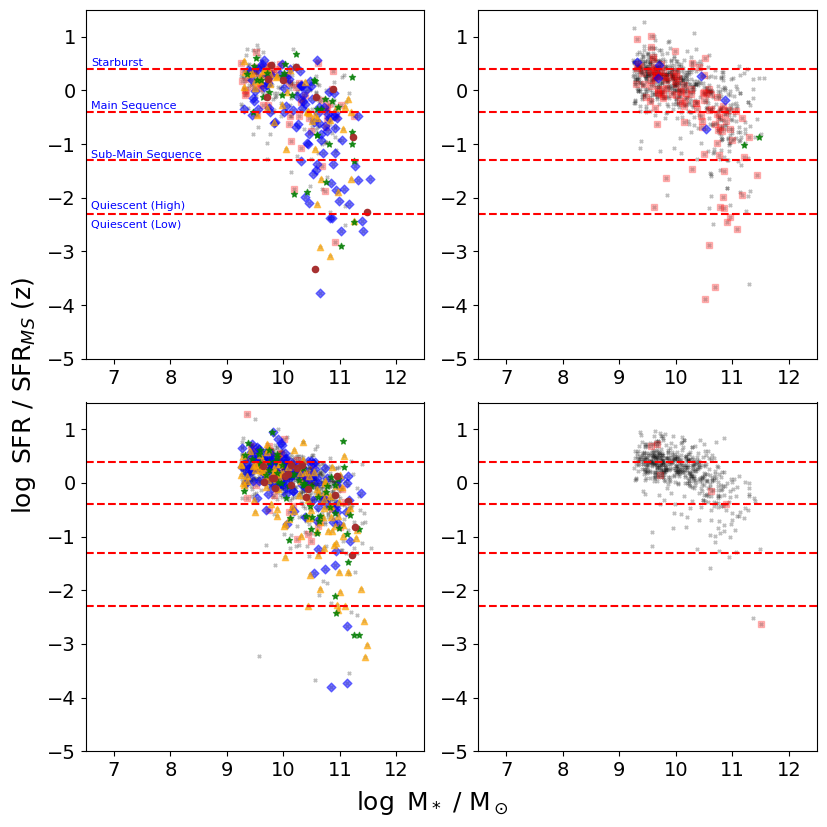

In [142]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))
counter = 1

marker = ['s', 'D', "^", '*', 'o']
colour = ['red', 'blue', 'orange', 'green', 'brown']
alpha = [0.25, 0.5, 0.60, 0.75, 0.95]

for i in range(2):
    for j in range(2):
        df_stage = df_comp.query(f'category == "stage{counter}"')
        df_stage.plot.scatter(
            x = 'lp_mass_best',
            y = 'sfr_sfr_ms',
            s = 5,
            marker = 'x',
            alpha = 0.25,
            color = 'black',
            ax = ax[i,j],
            # figsize = (8,8),
            xlabel = '',
            ylabel = '',
            xlim = [6.5, 12.5],
            ylim = [-5, 1.5],
            fontsize = 14,
        )
        
        for i_bin in range(len(bins)-1):
            min_b = bins[i_bin]
            max_b = bins[i_bin+1]
            
            df_proj_sep = df_proj.query('proj_seps > @min_b and proj_seps <= @max_b')
            
            df_prim = df_proj_sep.query(f'prim_cat == "stage{counter}"')
            df_sec = df_proj_sep.query(f'sec_cat == "stage{counter}"')
            
            df_prim.plot.scatter(
                x = 'lp_mass_best_prim',
                y = 'prim_sfr_ms',
                s = 20,
                marker = marker[i_bin],
                alpha = alpha[i_bin],
                color = colour[i_bin],
                ax = ax[i,j],
                # figsize = (8,8),
                xlabel = '',
                ylabel = '',
                xlim = [6.5, 12.5],
                ylim = [-5, 1.5],
            )
            
            df_sec.plot.scatter(
                x = 'lp_mass_best_sec',
                y = 'sec_sfr_ms',
                s = 20,
                marker = marker[i_bin],
                alpha = alpha[i_bin],
                color = colour[i_bin],
                ax = ax[i,j],
                # figsize = (8,8),
                xlabel = '',
                ylabel = '',
                xlim = [6.5, 12.5],
                ylim = [-5, 1.5],
            )
        
        ax[i,j].axhline(0.4, color='red', linestyle='--')
        ax[i,j].axhline(-0.4, color = 'red', linestyle='--')
        ax[i,j].axhline(-1.3, color = 'red', linestyle = '--')
        ax[i,j].axhline(-2.3, color = 'red', linestyle='--')
        if counter == 1:
            ax[i,j].text(6.6, 0.45, 'Starburst', fontsize = 8, color='blue')
            ax[i,j].text(6.6, -0.35, 'Main Sequence', fontsize = 8, color='blue')
            ax[i,j].text(6.6, -1.25, 'Sub-Main Sequence', fontsize = 8, color='blue')
            ax[i,j].text(6.6, -2.20, 'Quiescent (High)', fontsize = 8, color='blue')
            ax[i,j].text(6.6, -2.55, 'Quiescent (Low)', fontsize = 8, color='blue')
        
        
        counter += 1
fig.text(0.5, -0.01, '$\log$ M$_*$ / M$_\odot$', ha='center', va='center', fontsize = 18)
fig.text(-0.01, 0.5, '$\log$ SFR / SFR$_{MS}$ (z)', ha='center', va='center', rotation='vertical', fontsize = 18)
fig.tight_layout()
# fig.savefig(f'{fig_folder}/sfr-clsf-dist.pdf', bbox_inches='tight')
plt.show()

In [143]:
def scatter_hist(x, y, ax, ax_histx, ax_histy, colour, alpha, marker):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, s = 20, color=colour, alpha = alpha, marker = marker)
    #threshold = 0.065
    # sns.kdeplot(x=x,y=y, ax=ax, thresh = 0.05, levels=8, color='orange')
    ax.set_xlim([6.5,12.5])
    ax.set_ylim([-5, 3.5])

    # now determine nice limits by hand:
    # binwidth = 0.15
    n_bins = 20
    # xymax = max(12.5, 3.5)
    # lim = (int(xymax/binwidth) + 1) * binwidth
    
    x_lims = [6.5, 12.5]
    y_lims = [-5, 3.5]

    x_bins = np.linspace(x_lims[0], x_lims[1], n_bins)
    y_bins = np.linspace(y_lims[0], y_lims[1], n_bins)
    ax_histx.hist(x, bins=x_bins, histtype = 'step', color = colour)
    ax_histy.hist(y, bins=y_bins, orientation='horizontal', histtype='step', color=colour)

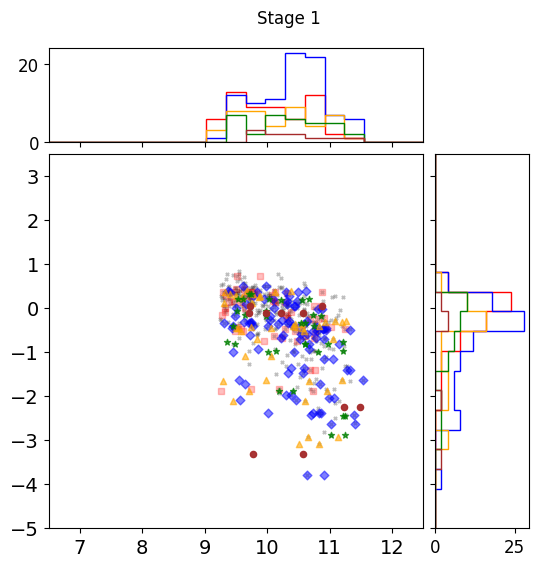

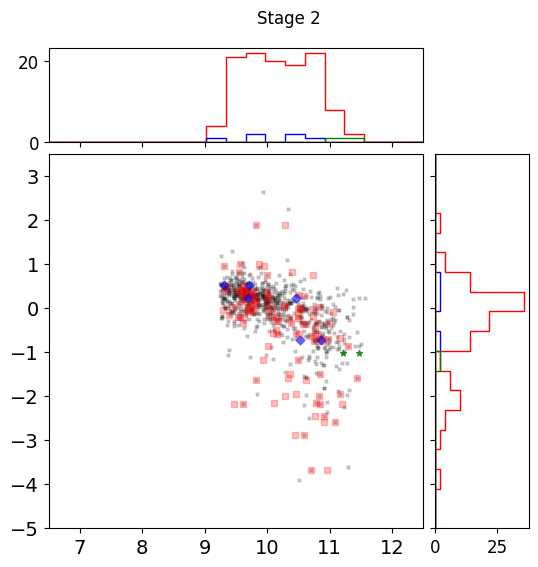

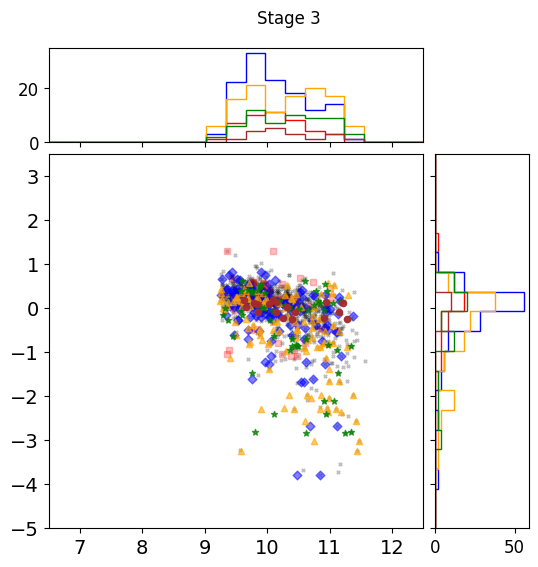

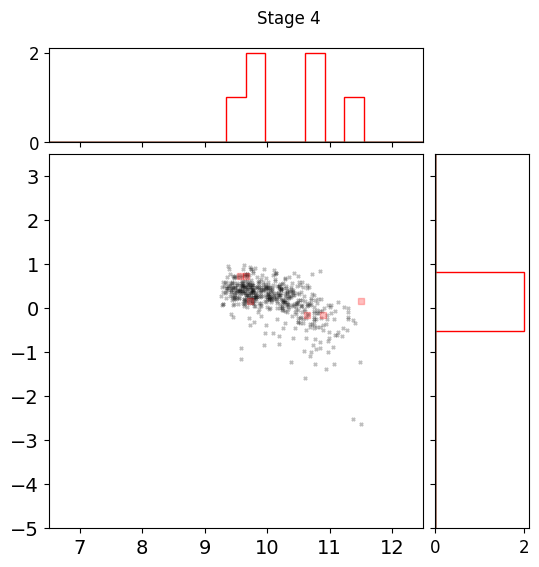

In [144]:
# colours = ['black','blue','red','orange']

for i in range(0,4):
    
    fig = plt.figure(figsize = (6,6))
    gs = fig.add_gridspec(2,2, width_ratios = (4,1), height_ratios = (1,4), left = 0.1, right = 0.9, bottom = 0.1, top = 0.9, wspace=0.05, hspace=0.05)

    ax = fig.add_subplot(gs[1,0])
    ax_histx = fig.add_subplot(gs[0,0],sharex=ax)
    ax_histy = fig.add_subplot(gs[1,1],sharey=ax)
    
    df_stage = df_comp.query(f'category == "stage{i+1}"')
    df_stage.plot.scatter(
            x = 'lp_mass_best',
            y = 'sfr_sfr_ms',
            s = 5,
            marker = 'x',
            alpha = 0.25,
            color = 'black',
            ax = ax,
            # figsize = (8,8),
            xlabel = '',
            ylabel = '',
            xlim = [6.5, 12.5],
            ylim = [-5, 1.5],
            fontsize = 14,
        )
    
    for i_bin in range(len(bins)-1):
        min_b = bins[i_bin]
        max_b = bins[i_bin+1]

        df_proj_sep = df_proj.query('proj_seps > @min_b and proj_seps <= @max_b')

        df_prim = df_proj_sep.query(f'prim_cat == "stage{i+1}"')
        df_sec = df_proj_sep.query(f'sec_cat == "stage{i+1}"')
        
        masses = list(df_prim.lp_mass_best_prim)
        for j in list(df_sec.lp_mass_best_sec):
            masses.append(j)
        
        sfr_fracs = list(df_prim.prim_sfr_ms)
        for j in list(df_sec.prim_sfr_ms):
            sfr_fracs.append(j)
    
        scatter_hist(np.array(list(masses)), np.array(list(sfr_fracs)), ax, ax_histx, ax_histy, colour[i_bin], alpha[i_bin], marker[i_bin])
        # scatter_hist(np.array(list(df_sec.lp_mass_best_sec)), np.array(list(df_sec.sec_sfr_ms)), ax, ax_histx, ax_histy, colour[i_bin], alpha[i_bin], marker[i_bin])

    
    fig.text(0.5, 0.95, f'Stage {i + 1}', ha='center', va='center', fontsize = 12)
    
    
plt.show()

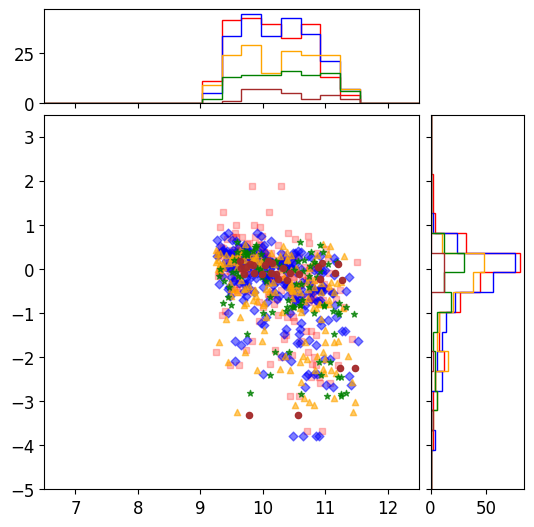

In [145]:
fig = plt.figure(figsize = (6,6))
gs = fig.add_gridspec(2,2, width_ratios = (4,1), height_ratios = (1,4), left = 0.1, right = 0.9, bottom = 0.1, top = 0.9, wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1,0])
ax_histx = fig.add_subplot(gs[0,0],sharex=ax)
ax_histy = fig.add_subplot(gs[1,1],sharey=ax)

for i_bin in range(len(bins)-1):
    min_b = bins[i_bin]
    max_b = bins[i_bin+1]

    df_proj_sep = df_proj.query('proj_seps > @min_b and proj_seps <= @max_b')

    df_prim = df_proj_sep#.query(f'prim_cat == "stage{i+1}"')
    df_sec = df_proj_sep#.query(f'sec_cat == "stage{i+1}"')
        
    masses = list(df_prim.lp_mass_best_prim)
    for j in list(df_sec.lp_mass_best_sec):
        masses.append(j)

    sfr_fracs = list(df_prim.prim_sfr_ms)
    for j in list(df_sec.prim_sfr_ms):
        sfr_fracs.append(j)

    scatter_hist(np.array(list(masses)), np.array(list(sfr_fracs)), ax, ax_histx, ax_histy, colour[i_bin], alpha[i_bin], marker[i_bin])
    # scatter_hist(np.array(list(df_sec.lp_mass_best_sec)), np.array(list(df_sec.sec_sfr_ms)), ax, ax_histx, ax_histy, colour[i_bin], alpha[i_bin], marker[i_bin])
        
plt.show()

### Calculating the Errors

In [146]:
df_confidence_mass = df_cat[['category', 'lp_mass_med_min68', 'lp_mass_med_max68']]
df_confidence_sfr = df_cat[['category', 'ez_sfr', 'ez_sfr_p500']]

In [147]:
df_mass_interval = (
    df_confidence_mass
    .assign(mass_int = df_confidence_mass.apply(lambda row: abs(row.lp_mass_med_max68 - row.lp_mass_med_min68), axis = 1))
)

In [148]:
mass_mean_confidence_int = np.mean(df_mass_interval.mass_int)

In [149]:
mass_mean_confidence_int

0.1174453059719834

In [150]:
df_confidence_sfr.head()

,category,ez_sfr,ez_sfr_p500
0,stage4,0.589695,0.591493
1,stage3,1.609304,1.620913
2,stage2,-0.987761,-0.988327
3,stage3,1.101499,1.101279
4,stage3,1.083541,1.076783


In [151]:
df_sfr_interval = (
    df_confidence_sfr
    .assign(sfr_int = df_confidence_sfr.apply(lambda row: 2* abs(row.ez_sfr_p500 - row.ez_sfr), axis = 1))
)

In [152]:
sfr_mean_confidence_int = np.mean(df_sfr_interval.sfr_int)

In [153]:
sfr_mean_confidence_int

0.12834544037829249

In [154]:
def weight_dist(arrs, bins=None, return_bins=True, renorm=False):
    # this will take 2 arrays of values from 2 different samples
    # e.g. redshift distributions from 2 samples
    # and return weights for each value such that the weighted
    # distributions of each sample will match.

    # note the bins need to be the same for both datasets
    # so either supply 1 number or 1 array of bin edges
    # also if you have fully specified the bins you don't need them returned
    # but if we've had to figure them out, you do need them returned
    # if you want to make sure you aren't under-weighting (e.g. if a whole dataset is
    # much larger than the other so you might always be able select >1 object
    # in dataset 1 for each object in dataset 2) then you can re-normalise to make
    # sure the max weight of both datasets is 1
    # Note, if the distributions cross this won't make a difference

    # weight arrays
    # w1 = np.zeros_like(arr1)
    # w2 = np.zeros_like(arr2)
    
    ws_list = []
    for i in arrs:
        ws_list.append(np.zeros_like(i))

    # if bins not specified, guess at them ourselves
    if bins is None:
        minsize = np.amin([    len(arr1),     len(arr2)])
        themin  = np.amin([np.amin(arr1), np.amin(arr2)])
        themax  = np.amax([np.amax(arr1), np.amax(arr2)])

        # on average 5 data points per bin, but at least 3 bins pls, max value is last bin edge
        bins = np.linspace(themin, themax, int(np.amax([(minsize/5)+1, 3])), endpoint=True)

    else:
        pass
        # because the np.histogram function can deal with distinguishing between number of bins or specific bins itself
        # so we don't have to
    hists = []
    hist1, thebins = np.histogram(arrs[0], bins=bins)  # returns (counts_arr, bins_arr)
    # use the bins from hist1 to make hist2
    # note: for these purposes, any values of hist2 outside the minmax range of hist1 should have 0 weight
    # which is taken care of by the zeros_like initialisation of w1 and w2 above
    # so it's fine for them to be excluded below
    hists.append(hist1)
    for i in arrs[1:]:
        hist_tmp, thebins = np.histogram(i, bins=thebins)
        hists.append(hist_tmp)

    # now step through the bins and assign weights
    for i_bin in range(len(thebins)-1):
        for i_hist in range(len(hists)-1):
            # zero-"index"ing these because they're indices and not values
            # and if I get them mixed up below I want this to error that there's no b2 or whatever
            b0 = thebins[i_bin]
            b1 = thebins[i_bin+1]

            count1 = hists[3][i_bin]
            count2 = hists[i_hist][i_bin]

            # don't miss any values and don't double-count
            if i_bin == 0:
                in_bin1 = (arrs[3] >= b0) & (arrs[3] <= b1)
                in_bin2 = (arrs[i_hist] >= b0) & (arrs[i_hist] <= b1)
            else: 
                in_bin1 = (arrs[3] >  b0) & (arrs[3] <= b1)
                in_bin2 = (arrs[i_hist] >  b0) & (arrs[i_hist] <= b1)


            # don't divide by 0 in the rest of the if/else
            if (count1 == 0) | (count2 == 0):
                ws_list[3][in_bin1] = 0.0
                ws_list[i_hist][in_bin2] = 0.0

            elif count1 < count2:
                # weight count2 values so the sum of wt2 in this bin equals count1
                # wt_fac will always be < 1
                wt_fac = float(count1)/float(count2)
                ws_list[3][in_bin1] = 1.0
                ws_list[i_hist][in_bin2] = wt_fac

            else:
                # weight count1 values so the sum of wt1 in this bin equals count2
                # wt_fac will always be <= 1
                wt_fac = float(count2)/float(count1)
                ws_list[3][in_bin1] = wt_fac
                ws_list[i_hist][in_bin2] = 1.0


    # now the weights should be determined
    # we can optionally re-normalise to make sure we are getting max value out of the datasets
    if renorm:
        if (np.sum(ws) > 0.00000) & (np.amax(w1) < 1.0):
            ws /= np.amax(ws)

        if (np.sum(ws) > 0.00000) & (np.amax(w2) < 1.0):
            ws /= np.amax(ws)


    if return_bins:
        return ws, thebins 
    else: 
        return ws_list

In [155]:
weights = weight_dist([masses_s1, masses_s2, masses_s3, masses_s4], bins = 20, renorm = False, return_bins = False)

In [156]:
masses = [masses_s1, masses_s2, masses_s3, masses_s4]
sfrs = [sfr_s1, sfr_s2, sfr_s3, sfr_s4]

In [157]:
bins

[0, 25, 50, 75, 100, 150]

In [158]:
def lower_beta(c,k,n):
    return dist.beta.ppf((1-c)/2, k+1, n-k+1)

In [159]:
def upper_beta(c,k,n):
    return dist.beta.ppf(1-(1-c)/2, k+1, n-k+1)

In [160]:
p_mass = [[],[],[],[]]
for counter, i in enumerate(weights):
    # Getting Weighted Masses
    mass = masses[counter]    
    # Getting Confidence Interval
    df_mass_stage = df_confidence_mass.query(f'category == "stage{counter+1}"')
    df_mass_interval = (
        df_mass_stage
        .assign(mass_int = df_mass_stage.apply(lambda row: abs(row.lp_mass_med_max68 - row.lp_mass_med_min68), axis = 1))
    )
    
    mass_mean_confidence_interval = np.mean(df_mass_interval.mass_int)
    
    _, bins = np.histogram(mass, bins=20)
    
    for j in range(len(bins)-1):
        lower_bin = bins[j]
        upper_bin = bins[j+1]
        
        mask = [(mass > lower_bin) & (mass <= upper_bin)][0].astype(bool)
        
        weights_bin = weights[counter][mask]
        mass_bin = mass[mask]
        
        counts = np.ones(len(mass_bin))
        counts = np.sum(weights_bin * counts)
        
        upper_p = upper_beta(0.683, counts, len(df_mass_stage))
        lower_p = lower_beta(0.683, counts, len(df_mass_stage))
                    
        if counts == 0:
            p_mass[counter].append([0,0])
        else:
            p_mass[counter].append([((counts / len(df_mass_stage)) - lower_p),  (upper_p - (counts / len(df_mass_stage)))])

In [161]:
p_mass[0]

[[0.0037501485847613834, 0.006076346929683309],
 [0.004660971288334394, 0.006946681498073447],
 [0.005663902147212289, 0.007896608361795752],
 [0.005128399032624534, 0.007390535479441643],
 [0.005455461554223138, 0.007699936051737362],
 [0.0034250911062512664, 0.005764055076348716],
 [0.004149221814097149, 0.006458549316210101],
 [0.004781566649211408, 0.0070613801591351],
 [0.004149221814097149, 0.006458549316210101],
 [0.004660971288334394, 0.006946681498073447],
 [0.004281965053509643, 0.006585382780302133],
 [0.004781566649211408, 0.0070613801591351],
 [0.004411359382907078, 0.0067088713021576755],
 [0.004781566649211408, 0.0070613801591351],
 [0.003099712336072799, 0.0054505972224976745],
 [0.0027466315263796007, 0.005109506647170274],
 [0.0016756383624931944, 0.004069255842183571],
 [0.0023577199392763168, 0.0047327014812546826],
 [0.0011109504012064599, 0.0035178723408583234],
 [0.0007690752421476656, 0.0031834381753783475]]

In [162]:
p_sfr = [[],[],[],[]]
for counter, i in enumerate(weights):
    # Getting Weighted Masses
    sfr = sfrs[counter]    
    # Getting Confidence Interval
    df_sfr_stage = df_confidence_sfr.query(f'category == "stage{counter+1}"')
    df_sfr_interval = (
        df_sfr_stage
        .assign(sfr_int = df_sfr_stage.apply(lambda row: 2* abs(row.ez_sfr_p500 - row.ez_sfr), axis = 1))
    )
    
    sfr_mean_confidence_interval = np.mean(df_sfr_interval.sfr_int)
    
    _, bins = np.histogram(sfr, bins=20)
    
    for j in range(len(bins)-1):
        lower_bin = bins[j]
        upper_bin = bins[j+1]
        
        mask = [(sfr > lower_bin) & (sfr <= upper_bin)][0].astype(bool)
        
        weights_bin = weights[counter][mask]
        mass_bin = sfr[mask]
        
        counts = np.ones(len(mass_bin))
        counts = np.sum(weights_bin * counts)
        
        upper_p = upper_beta(0.683, counts, len(df_sfr_stage))
        lower_p = lower_beta(0.683, counts, len(df_sfr_stage))
                    
        if counts == 0:
            p_sfr[counter].append([0,0])
        else:
            p_sfr[counter].append([((counts / len(df_sfr_stage)) - lower_p),  (upper_p - (counts / len(df_sfr_stage)))])

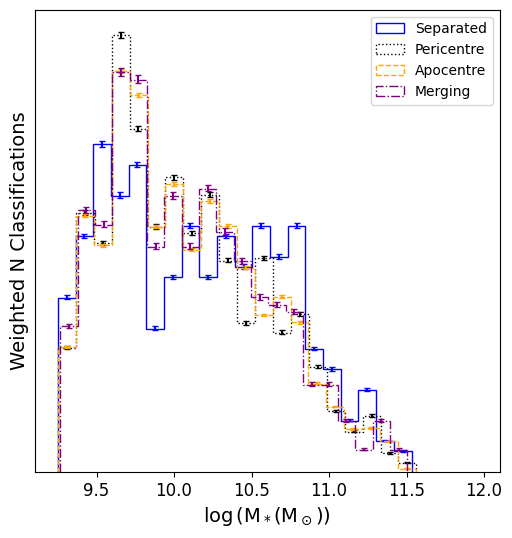

In [163]:
fig, ax = plt.subplots(figsize = (6,6))

colours = ['blue','black','orange','purple']
linestyles = ['solid', 'dotted','dashed','dashdot']
for i in range(4):
    bin_counts, bins = np.histogram(masses[i], bins = 20, weights=weights[i])
    bincenters = 0.5 * (bins[1:] + bins[:-1])
    
    error_array = np.asarray(p_mass[i]).T
    
    ax.hist(masses[i], bins = bins, histtype='step', color=colours[i], weights=weights[i], density = True, linestyle=linestyles[i])
    ax.errorbar(bincenters, bin_counts / (np.sum(bin_counts) * np.diff(bins)), yerr=error_array, linestyle = '', color=colours[i], barsabove=True, capsize=2.5)

plt.legend(['Separated','Pericentre','Apocentre','Merging'], loc='upper right')
plt.xlim([9.1,12.1])
# plt.ylim([0, 0.9])
plt.tick_params(left = False, labelleft=False)
plt.xlabel('$\log$(M$_*$(M$_\odot$))', fontsize = 14)
plt.ylabel('Weighted N Classifications', fontsize = 14)
plt.savefig(f'{fig_folder}/stellar-mass-dist.pdf', bbox_inches = 'tight')
plt.show()

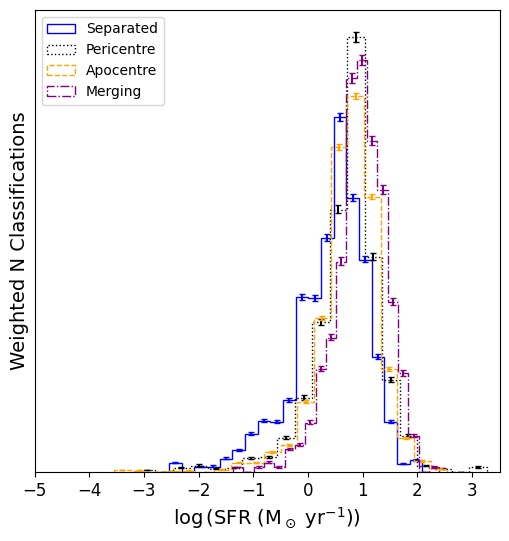

In [164]:
fig, ax = plt.subplots(figsize = (6,6))

colours = ['blue','black','orange','purple']
linestyles = ['solid', 'dotted','dashed','dashdot']
for i in range(4):
    bin_counts, bins = np.histogram(sfrs[i], bins = 20, weights=weights[i])
    bincenters = 0.5 * (bins[1:] + bins[:-1])
    
    error_array = np.asarray(p_sfr[i]).T
    
    ax.hist(sfrs[i], bins = 20, histtype='step', color=colours[i], weights=weights[i], density = True, linestyle=linestyles[i])
    ax.errorbar(bincenters, bin_counts / (np.sum(bin_counts) * np.diff(bins)), yerr=error_array, linestyle = '', color=colours[i], capsize = 2.5)

plt.legend(['Separated','Pericentre','Apocentre','Merging'], loc='upper left')
plt.xlim([-5,3.5])
# plt.ylim([0, 1.10])
plt.xlabel('$\log$(SFR (M$_\odot$ yr$^{-1}$))', fontsize = 14)
plt.ylabel('Weighted N Classifications', fontsize = 14)
plt.tick_params(left = False, labelleft=False)
plt.savefig(f'{fig_folder}/sfr_dist.pdf', bbox_inches = 'tight')
plt.show()

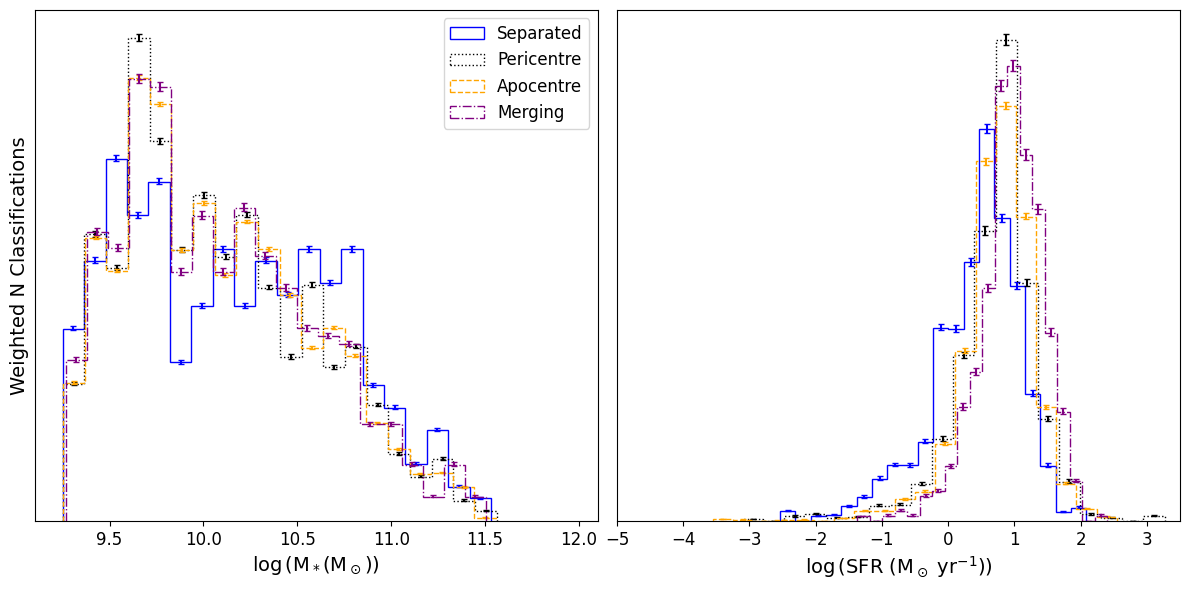

In [165]:
fig, ax = plt.subplots(ncols = 2, figsize = (12,6))
for p in range(2):
    if p == 0:
        for i in range(4):
            bin_counts, bins = np.histogram(masses[i], bins = 20, weights=weights[i])
            bincenters = 0.5 * (bins[1:] + bins[:-1])

            error_array = np.asarray(p_mass[i]).T

            ax[0].hist(masses[i], bins = 20, histtype='step', color=colours[i], weights=weights[i], density = True, linestyle=linestyles[i])
            ax[0].errorbar(bincenters, bin_counts / (np.sum(bin_counts) * np.diff(bins)), yerr=error_array, linestyle = '', color=colours[i], barsabove=True, capsize=2.5)
    elif p == 1:
        for i in range(4):
            bin_counts, bins = np.histogram(sfrs[i], bins = 20, weights=weights[i])
            bincenters = 0.5 * (bins[1:] + bins[:-1])

            error_array = np.asarray(p_sfr[i]).T

            ax[1].hist(sfrs[i], bins = 20, histtype='step', color=colours[i], weights=weights[i], density = True, linestyle=linestyles[i])
            ax[1].errorbar(bincenters, bin_counts / (np.sum(bin_counts) * np.diff(bins)), yerr=error_array, linestyle = '', color=colours[i], capsize = 2.5)

ax[0].set_xlim([9.1,12.1])
ax[1].set_xlim([-5,3.5])
ax[0].legend(['Separated','Pericentre','Apocentre','Merging'], loc='upper right', fontsize = 12)
# plt.ylim([0, 1.10])
ax[0].set_xlabel('$\log$(M$_*$(M$_\odot$))', fontsize = 14)
ax[1].set_xlabel('$\log$(SFR (M$_\odot$ yr$^{-1}$))', fontsize = 14)
ax[0].set_ylabel('Weighted N Classifications', fontsize = 14)
ax[0].tick_params(left = False, labelleft=False)
ax[1].tick_params(left = False, labelleft=False)
fig.tight_layout()
fig.savefig(f'{fig_folder}/mass_sfr_dist_comb.pdf', bbox_inches = 'tight', dpi = 720)
plt.show()